In this notebook, we ran scope for the Suzuki dataset.

NOTE: As this dataset only served illustrative purposes that the algorithm can be used for multi-objective scenarios, only 20 random seeds were used.

In [1]:

from pathlib import Path
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from umap import UMAP
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
from Code.predictor import ScopeBO
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

### Run scopes

In [2]:
# load the dataset
df_labelled = pd.read_csv(f"suzuki_labelled_data.csv", index_col=0,header=0)

# make a scaled copy of the features
df_data = df_labelled.copy(deep=True)
df_data = df_data.drop(columns=['objective_conversion','objective_selectivity'])  # drop the objective values
df_data = pd.DataFrame(scale(df_data),df_data.index,df_data.columns)

objectives = ["objective_conversion","objective_selectivity"]
wdir = Path(".")

# fit and save a UMAP for the dataset
fit = UMAP(n_neighbors=40,min_dist=0.7,n_components=2,metric="euclidean",random_state=12)
df_umap = pd.DataFrame(fit.fit_transform(df_data),df_data.index,["UMAP1","UMAP2"])
df_umap.to_csv("suzuki_UMAP_coords.csv")


In order to calculate scope scores for this dataset, we first established objective bounds for the normalization of them using the workflow established in the hyperparameter optimization for the ArI oxidative addtion dataset.

NOTE: batch size 2 skipped because it gave numerical errors

In [3]:
# # High vendi and low objective bounds with the explorative acquisition function with max pruning for the respective batch size
# run_settings = {1: 0, 3: 0, 4: 0, 2: 0}
# for batch_size in run_settings.keys():
#     Benchmark().collect_data(
#         filename_labelled = f"./suzuki_labelled_data.csv",
#         name_results = f"./Results_Data/bounds/greedy40_b{batch_size}",
#         objectives=['objective_conversion',"objective_selectivity"],
#         budget = 40,
#         batches= [batch_size],
#         Vendi_pruning_fractions = [run_settings[batch_size]],
#         seeds = 20,
#         acquisition_function_mode= "greedy",
#         pruning_metric= "vendi_batch",
#         init_sampling_method="random")

In [4]:
# # High vendi and low objective bounds with the explorative acquisition function with max pruning for the respective batch size
# run_settings = {1: 7, 2: 15, 3: 22, 4: 30}
# for batch_size in run_settings.keys():
#     Benchmark().collect_data(
#         filename_labelled = f"./suzuki_labelled_data.csv",
#         name_results = f"./Results_Data/bounds/explorative40_b{batch_size}",
#         objectives=['objective_conversion',"objective_selectivity"],
#         budget = 40,
#         batches= [batch_size],
#         Vendi_pruning_fractions = [run_settings[batch_size]],
#         seeds = 20,
#         acquisition_function_mode= "explorative",
#         pruning_metric= "vendi_batch",
#         init_sampling_method="random")

Get the objective and Vendi score bounds by analyzing the scopes

In [5]:
# Use the results of the explorative acqusition function (max pruning) with scope size 40, to get the lower bounds for the objective_conversion and the upper bounds for the objective_selectivity 
# (as it is a minimization task) and the vendi score.
dfs_bounds_greedy = {}
for metric in ["objective_conversion","objective_selectivity","vendi"]:
    dfs_metric = {}
    for batch_size in [1,2,3,4]:
        dfs_metric[batch_size] = Benchmark().heatmap_plot(type_results=metric,name_results=f"./Results_Data/bounds/greedy40_b{batch_size}",budget=40,show_plot=False)
    greedy_values = pd.concat(dfs_metric,axis=1)
    greedy_values.columns = [1,2,3,4]
    greedy_values = greedy_values.stack().reset_index(drop=True)
    dfs_bounds_greedy[metric] = pd.DataFrame({metric: greedy_values})
bounds_greedy = pd.concat(dfs_bounds_greedy,axis=1)
bounds_greedy.columns = ["objective_conversion","objective_selectivity","vendi"]
objective_conversion_max = bounds_greedy["objective_conversion"].max()
objective_selectivity_max = bounds_greedy["objective_selectivity"].max()
vendi_min = bounds_greedy["vendi"].min()
print(f"upper bounds objective_conversion: {objective_conversion_max}")
print(f"upper bounds objective_selectivity: {objective_selectivity_max}")
print(f"lower bounds vendi score: {vendi_min}")

upper bounds objective_conversion: 55.25412500000001
upper bounds objective_selectivity: 67.02590586964179
lower bounds vendi score: 6.850374670341066


In [6]:
# Use the results of the explorative acqusition function (max pruning) with scope size 40, to get the lower bounds for the objective_conversion and the upper bounds for the objective_selectivity 
# (as it is a minimization task) and the vendi score.
dfs_bounds_explorative = {}
for metric in ["objective_conversion","objective_selectivity","vendi"]:
    dfs_metric = {}
    for batch_size in [1,2,3,4]:
        dfs_metric[batch_size] = Benchmark().heatmap_plot(type_results=metric,name_results=f"./Results_Data/bounds/explorative40_b{batch_size}",budget=40,show_plot=False)
    explorative_values = pd.concat(dfs_metric,axis=1)
    explorative_values.columns = [1,2,3,4]
    explorative_values = explorative_values.stack().reset_index(drop=True)
    dfs_bounds_explorative[metric] = pd.DataFrame({metric: explorative_values})
bounds_explorative = pd.concat(dfs_bounds_explorative,axis=1)
bounds_explorative.columns = ["objective_conversion","objective_selectivity","vendi"]
objective_conversion_min = bounds_explorative["objective_conversion"].min()
objective_selectivity_min = bounds_explorative["objective_selectivity"].min()
vendi_max = bounds_explorative["vendi"].max()
print(f"lower bounds objective_conversion: {objective_conversion_min}")
print(f"lower bounds objective_selectivity: {objective_selectivity_min}")
print(f"upper bounds vendi score: {vendi_max}")

lower bounds objective_conversion: 15.634
lower bounds objective_selectivity: 20.062109934580953
upper bounds vendi score: 16.10129419671874


In [7]:
# Record the bounds
objective_conversion_bounds = (objective_conversion_max,objective_conversion_min)
objective_selectivity_bounds = (objective_selectivity_max,objective_selectivity_min)
vendi_bounds = (vendi_max,vendi_min)
bounds = {"objective_conversion": objective_conversion_bounds,
          "objective_selectivity": objective_selectivity_bounds,
          "vendi": vendi_bounds}

After having established the bounds for the objectives, we can run the scopes with different acquisition functions using the optimized conditions and also without Vendi pruning.

In [8]:
# for acq in ["balanced","greedy","random"]:
#     for pruning in [False,True]:
#         if pruning:
#             pruning_label = "pruning"
#             pruning_fractions = 13
#         else:
#             pruning_label = "no-pruning"
#             pruning_fractions = 0
#         Benchmark().collect_data(
#             filename_labelled = f"./suzuki_labelled_data.csv",
#             name_results = f"./Results_Data/scope_{acq}_{pruning_label}",
#             objectives=['objective_conversion',"objective_selectivity"],
#             budget = 27,
#             batches= [3],
#             Vendi_pruning_fractions = [pruning_fractions],
#             seeds = 20,
#             acquisition_function_mode= acq,
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random")

In [9]:
# # human-like conventional selection
# Benchmark().collect_data(
#     filename_labelled = f"./suzuki_labelled_data.csv",
#     name_results = f"./Results_Data/scope_human-like-acq",
#     objectives=['objective_conversion',"objective_selectivity"],
#     budget = 27,
#     batches= [3],
#     Vendi_pruning_fractions = [5],
#     seeds = 20,
#     acquisition_function_mode= "greedy",
#     pruning_metric= "vendi_batch",
#     init_sampling_method="random")

Get the results

Scope score:


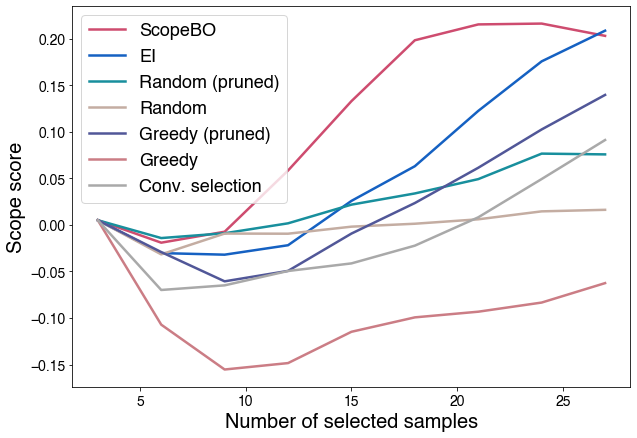

Average_objective:


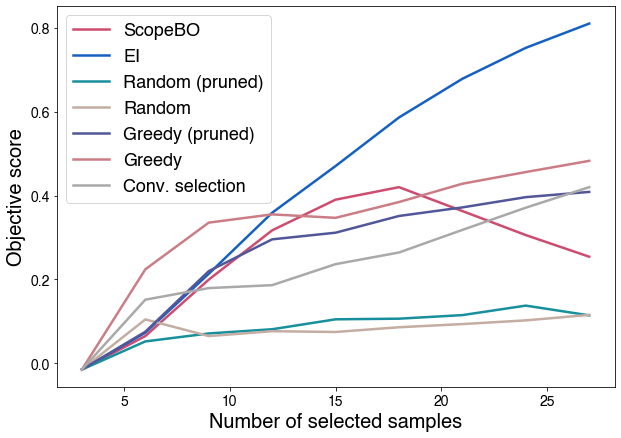

Vendi score:


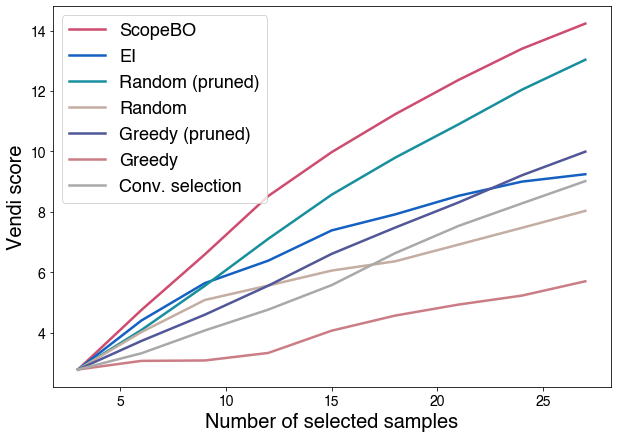

In [10]:
for type_results in ["Scope","Objective","Vendi"]:
    dfs = {}
    for acq in ["EI","Random","Greedy","Conv. selection"]:
        if acq == "EI":
            acq_label = "balanced"
        elif acq == "Conv. selection":
            acq_label = "human-like-acq"
        else:
            acq_label = acq.lower()
        for pruning in [True,False]:
            if pruning:
                pruning_label = "_pruning"
                pruning_flag = "with"
            else:
                pruning_label = "_no-pruning"
                pruning_flag = "without"
            if acq == "Conv. selection":
                pruning_label = ""
            dfs_progress = Benchmark().progress_plot(budget=27, type_results= type_results,
                                    name_results=f"./Results_Data/scope_{acq_label}{pruning_label}",show_plot=False,
                                    bounds={"objective_conversion":objective_conversion_bounds,"objective_selectivity":objective_selectivity_bounds,"vendi":vendi_bounds})
            dfs[acq+pruning_label] = dfs_progress["means"]

    df_combined = pd.concat(dfs,axis=1)
    df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
    df_combined.rename(columns={"EI_pruning":"ScopeBO"},inplace=True)
    df_combined = df_combined[["ScopeBO"] + [col for col in df_combined.columns if col != "ScopeBO"]]
    label_dict = {col: col for col in df_combined.columns}
    for key,val in label_dict.items():
        if "_no-pruning" in val:
            label_dict[key] = val.split("_")[0]
        elif "pruning" in val:
            label_dict[key] = val.split("_")[0] + " (pruned)"
    df_combined.rename(columns=label_dict,inplace=True)
    if type_results == "Objective":
        print("Average_objective:")
    else:
        print(f"{type_results} score:")
    # Plot.
    plt.figure(figsize=(10,7))
    for j,col in enumerate(df_combined.columns):
        style = '-' if j <= 6 else '--' if j <= 13 else ':'
        plotting = df_combined[col][df_combined[col].notna()]
        plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
    plt.xlabel('Number of selected samples',fontsize=20)
    plt.ylabel(f"{type_results} score",fontsize=20)
    plt.legend(fontsize=18)
    plt.show()

The scope scores of ScopeBO and EI are nearly the same. ScopeBO achieved a higheer Vendi score, but EI outperformed it in terms of the objective score. The objective score of ScopeBO still remains slightly higher than the average of the full dataset (0.25 vs. 0.23 for full dataset.)

# Doyle clustering for comparison

Only the Doyle clustering algorithm can be carried out as the Glorius one takes SMILES strings as input that are not available for this reaction optimization dataset.

In [11]:
# A scaled dataframe containing the features was already generated in the beginning of this notebook. Check how many dimensions there are.
print(f"There are {len(df_data.columns)} dimensions in the dataset.")

There are 169 dimensions in the dataset.


In [12]:
# define the dimensionalities of the reduced representation to study
dims = [169, 150, 125, 100, 75, 50, 25, 20, 15, 10, 5, 2]

# function to calculate silhouette scores
def silhouette_scores_hierarchical(data, n_cls_list):
    """helper function to compute a silhouette score for hierarchical clustering using Ward linkage"""
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

# dictionary to store data at different levels of dimensionality reduction
n_neighbors = int(np.sqrt(df_data.shape[1]))
dfs = {}
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors,
                                    random_state=0).fit_transform(df_data),index=df_data.index)

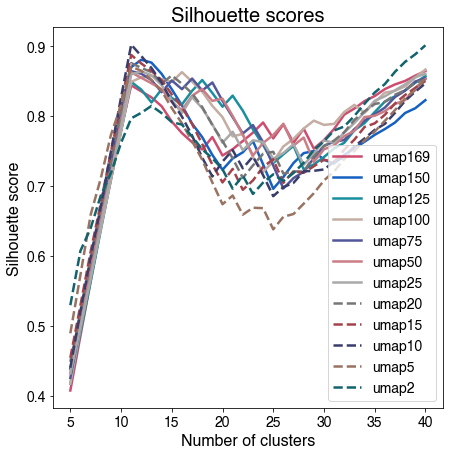

,Representation,Nr_clusters,Silh_score,Representation (min 15 clusters),Nr_clusters (min 15 clusters),Silh_score (min 15 clusters)
Results,umap10,11.0,0.902173,umap2,40.0,0.901146


In [13]:
# range of scope sizes to be studied
N_CLS_list = list(range(5,41))
# min number of clusters for the scope
min_clust = 15
# df to save the results of the silhouette score analysis
best_silh_scores = pd.DataFrame(np.nan,index=["Results"],columns=["Representation","Nr_clusters", "Silh_score",
                                                               f"Representation (min {min_clust} clusters)", 
                                                               f"Nr_clusters (min {min_clust} clusters)",
                                                               f"Silh_score (min {min_clust} clusters)"])

plt.figure(figsize=(7,7))
plt.title("Silhouette scores")
plt.xlabel("Number of clusters",fontsize=16)
plt.ylabel("Silhouette score",fontsize=16)

# populate silhouette scores for all number of clusters and all dimensionality reductions
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)
for j,col in enumerate(silh_scores.columns):
    style = '-' if j <= 6 else '--' if j <= 13 else ':'
    plotting = silh_scores[col][silh_scores[col].notna()]
    plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)

# record the representation that gives the best silhouette score
max_position = silh_scores.stack().idxmax()
best_silh_scores.loc["Results","Representation"] = max_position[1]
best_silh_scores.loc["Results","Nr_clusters"] = int(max_position[0])
best_silh_scores.loc["Results","Silh_score"] = silh_scores.max().max()
silh_scores_pruned = silh_scores.loc[silh_scores.index >= min_clust]
max_position_pruned = silh_scores_pruned.stack().idxmax()
best_silh_scores.loc["Results",f"Representation (min {min_clust} clusters)"] = max_position_pruned[1]
best_silh_scores.loc["Results",f"Nr_clusters (min {min_clust} clusters)"] = int(max_position_pruned[0])
best_silh_scores.loc["Results",f"Silh_score (min {min_clust} clusters)"] = silh_scores_pruned.max().max()
plt.legend()
plt.show()

best_silh_scores

The highest silhouette score was obtained with 11 clusters. As a scope of 11 substrates is too small, we also determined the best silhouette score for 15 or more clusters which was achieved using the umap2 representation and 40 clusters. We used this embedding to determine the scope.

In [14]:
embedding = best_silh_scores.loc["Results",f"Representation (min {min_clust} clusters)"]
nr_clusters = best_silh_scores.loc["Results",f"Nr_clusters (min {min_clust} clusters)"]

# Clustering
z = hierarchy.linkage(dfs[embedding],method ="ward",metric="euclidean")
clusters = hierarchy.fcluster(z,nr_clusters,criterion="maxclust")

# Assign to samples
df_data["clusters"] = clusters
df_umap["clusters"] = clusters

Visualization of the clusters:


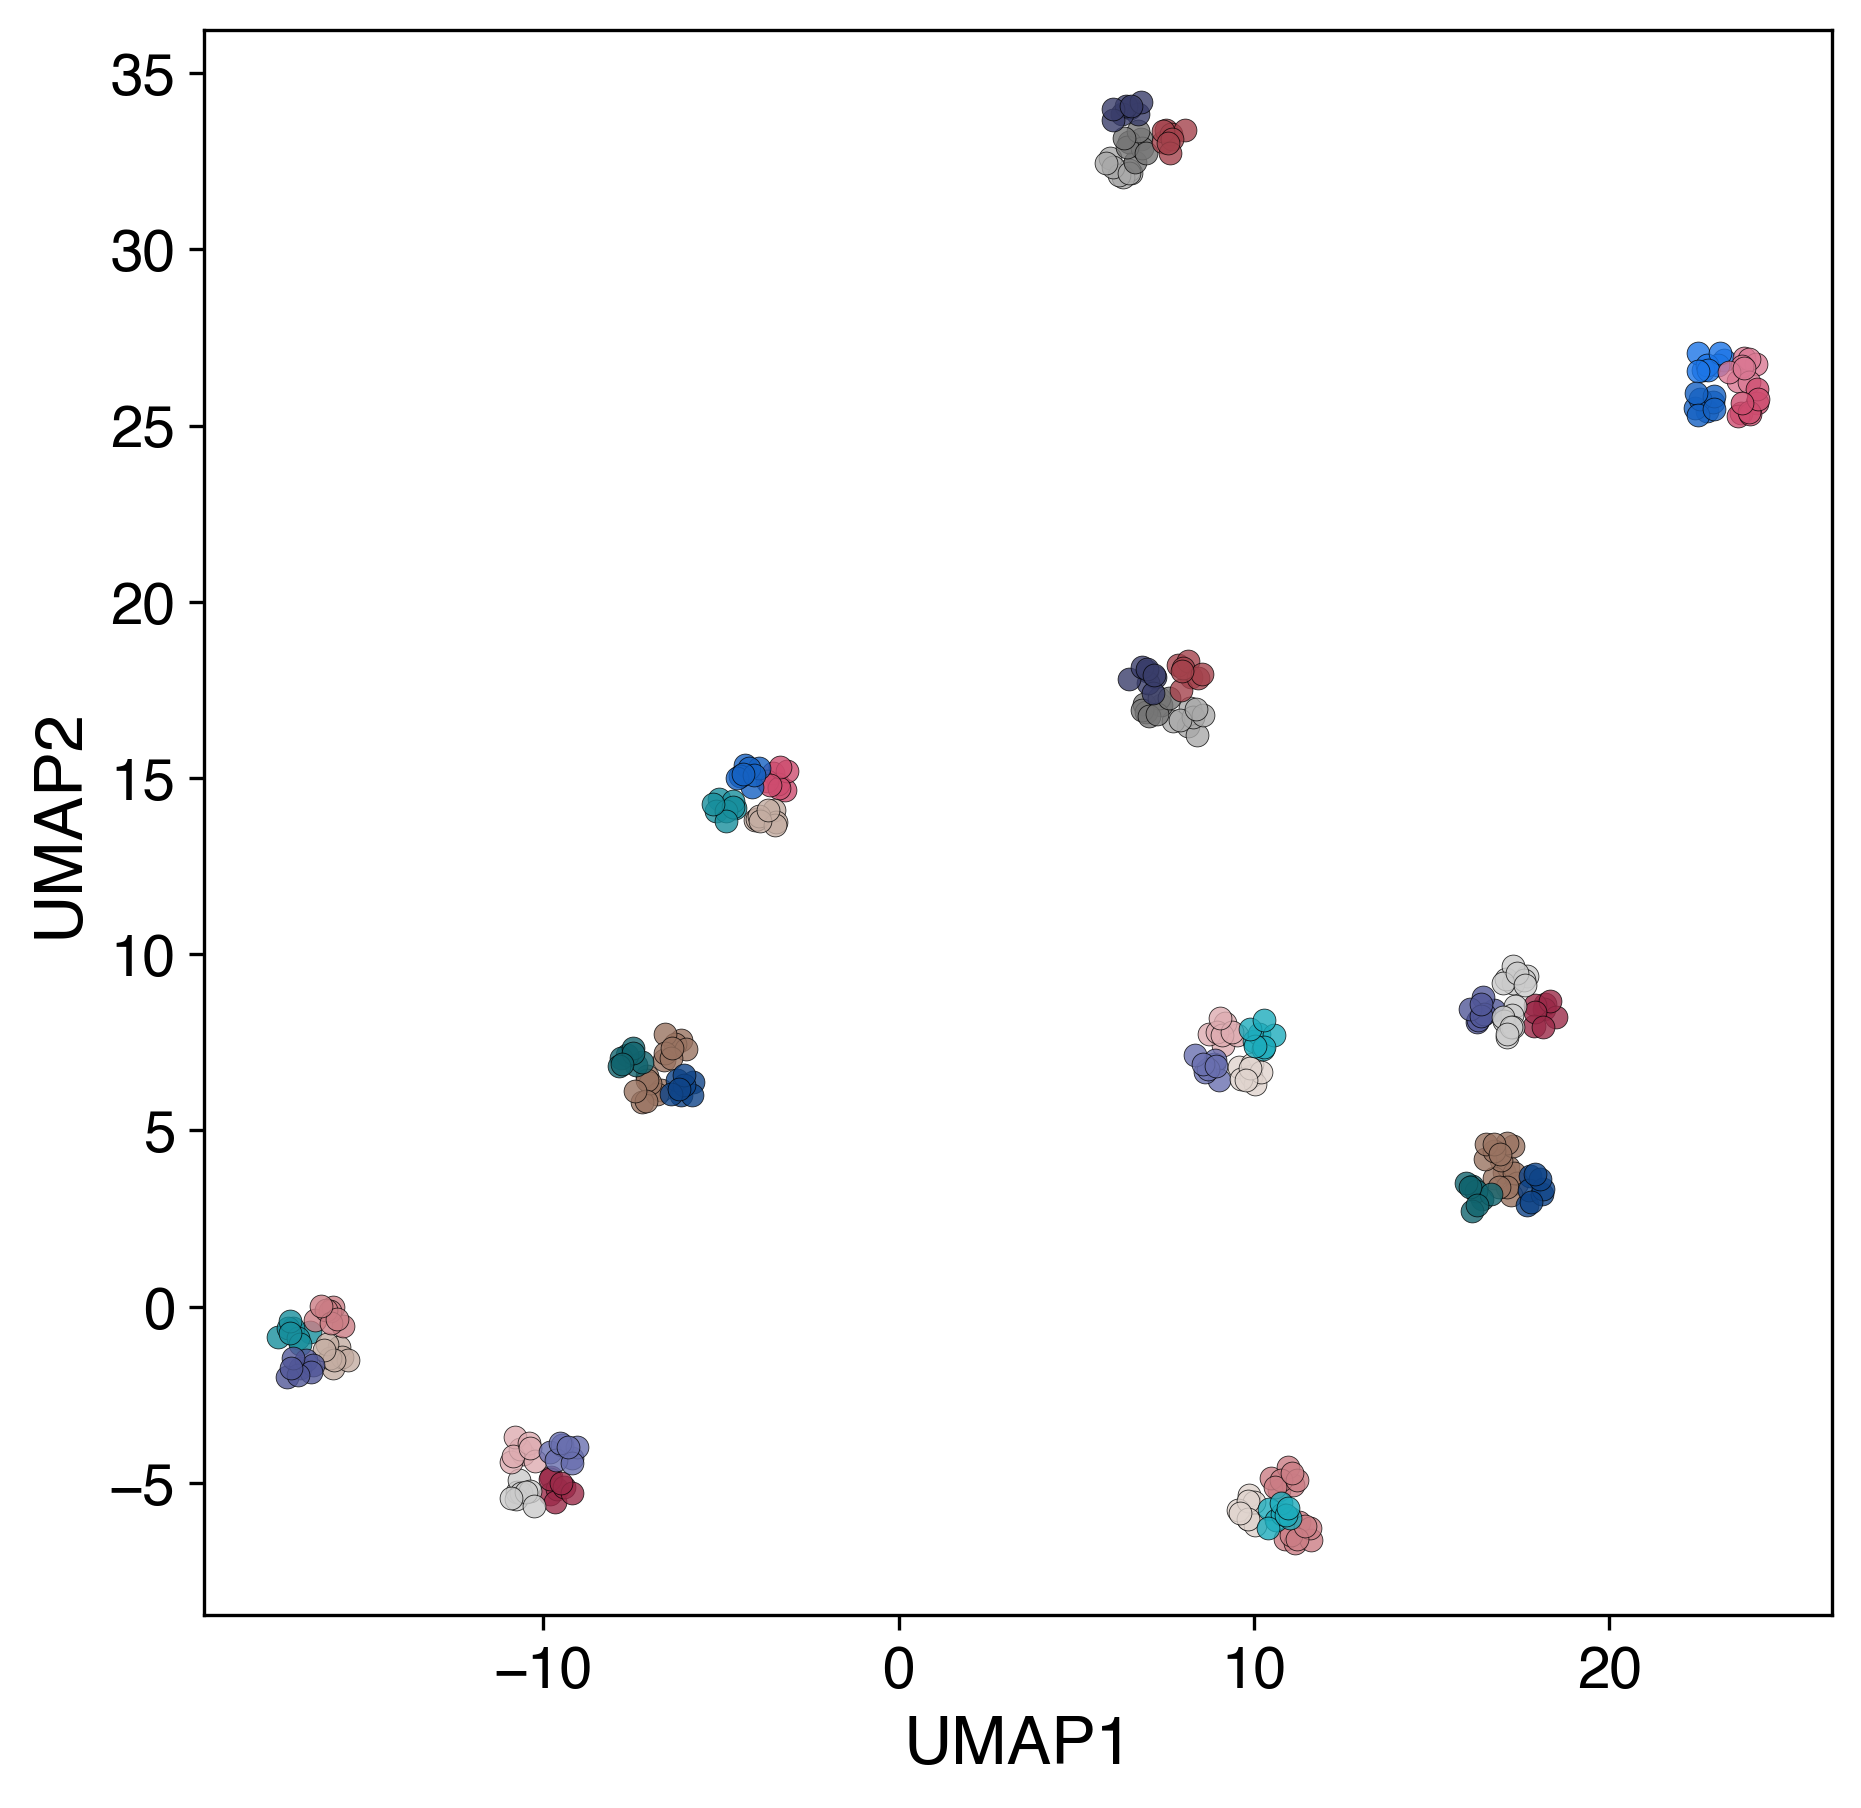

Please note that all colors are used for two different clusters due to the large number of clusters.


In [15]:
# draw the clusters
print("Visualization of the clusters:")

# defining the colors
all_colors = all_colors * 100
colors = {i: all_colors[i] for i in range(len(clusters))}

plt.figure(figsize=(7,7),dpi=300)
plt.xlabel("UMAP1",fontsize=16)
plt.ylabel("UMAP2",fontsize=16)

for cluster_id in sorted(df_umap['clusters'].unique()):
    color_id = cluster_id-1  # colors are zero-index, but clusters one-indexed
    cluster_data = df_umap[df_umap['clusters'] == cluster_id]
    plt.scatter(
        cluster_data['UMAP1'], cluster_data['UMAP2'],
        color=colors[color_id],
        label=f'Cluster {cluster_id}',
        s=30, alpha=0.8, edgecolor='k', linewidth=0.2
    )
plt.show()
print("Please note that all colors are used for two different clusters due to the large number of clusters.")

In [16]:
# function to calculate the scope score
def calculate_scope_score(av_conv,av_sele,Vendi_score,bounds):
    scaled_conv = (av_conv - bounds["objective_conversion"][1])/(bounds["objective_conversion"][0] - bounds["objective_conversion"][1])
    scaled_sele = (av_sele - bounds["objective_selectivity"][1])/(bounds["objective_selectivity"][0] - bounds["objective_selectivity"][1])
    scaled_obj = (scaled_conv + scaled_sele)/2
    scaled_Vendi = (Vendi_score - bounds["vendi"][1])/(bounds["vendi"][0] - bounds["vendi"][1])

    return scaled_obj * scaled_Vendi, scaled_obj

In [17]:
# calculate the center-most point of each cluster and the Vendi score for the resulting samples
scope_results = pd.DataFrame(np.nan,index=["Results"],columns=["Average conversion","Average selectivity",
                                                               "Average mean norm. objective","Vendi score","Scope score"])

cluster_convs = [] # list to save the yields
cluster_seles = [] # list to save the costs
df_vendi = df_labelled.copy(deep=True)
df_vendi["obj_scaled"] = "PENDING"  # reset the rate data so that only the selected points will have a rate
for cluster in range(max(df_data["clusters"].unique())):  # loop through all clusters
    cluster = cluster+1  # +1 because the range object is 0-indexed whereas the cluster are 1-indexed
    df_cluster = df_data.loc[df_data["clusters"]== cluster]  # look at the points in the current cluster
    df_cluster = df_cluster.drop(columns=["clusters"])  # drop the cluster column to only keep the features (df_clustering did not contain the rate data)
    centroid = df_cluster.mean().values  # this is the center of the cluster
    distances = cdist(df_cluster,[centroid],metric="cityblock").flatten()  # calculate the distances to the center
    df_cluster["distances"] = distances

    centermost_point = df_cluster[df_cluster["distances"] == df_cluster["distances"].min()].index[0].item()  # get the center-most point
    yield_clusterpoint = df_labelled.at[centermost_point,"objective_conversion"]  # get the rate data for the center-most point
    cost_clusterpoint = df_labelled.at[centermost_point,"objective_selectivity"]  # get the rate data for the center-most point

    df_vendi.loc[centermost_point,"obj_scaled"] = "1"  # put a label for the vendi score calculation (value is not important)
    cluster_convs.append(yield_clusterpoint)  # save the point
    cluster_seles.append(cost_clusterpoint)  # save the other objective
av_conv = sum(cluster_convs)/len(cluster_convs)
av_sele = sum(cluster_seles)/len(cluster_seles)

scope_results.loc["Results","Average conversion"] = av_conv
scope_results.loc["Results","Average selectivity"] = av_sele
df_vendi.to_csv(wdir.joinpath("df_clustering_vendi.csv"),index=True,header=True)  # save the file (as the Vendi score calculation needs a file as input)
Vendi_score = ScopeBO().get_vendi_score(objectives=["objective_conversion","objective_selectivity","obj_scaled"],
                                        directory=".",filename="df_clustering_vendi.csv")  # calculate the vendi score
scope_results.loc["Results","Vendi score"] = Vendi_score
scope_score, scaled_obj = calculate_scope_score(av_conv,av_sele,Vendi_score,bounds)
scope_results.loc["Results","Scope score"] = scope_score
scope_results.loc["Results","Average mean norm. objective"] = scaled_obj

In [18]:
# make an additional column in the labelled dataset with the scaled mean objective
min_yield = df_labelled["objective_conversion"].min()
max_yield = df_labelled["objective_conversion"].max()
min_cost = df_labelled["objective_selectivity"].min()
max_cost = df_labelled["objective_selectivity"].max()
df_labelled["obj_conversion_scaled"] = (df_labelled["objective_conversion"] - min_yield)/(max_yield - min_yield)
df_labelled["obj_selectivity_scaled"] = (df_labelled["objective_selectivity"] - min_cost)/(max_cost - min_cost)
df_labelled["obj_scaled"] = (df_labelled["obj_conversion_scaled"] + df_labelled["obj_selectivity_scaled"])/2

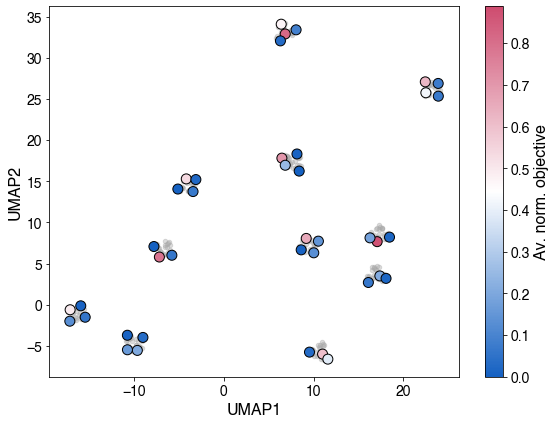

Scope results:


,Average conversion,Average selectivity,Average mean norm. objective,Vendi score,Scope score
Results,19.92,27.140604,0.12945,15.732976,0.124296


In [19]:
plt.figure(figsize=(8,6))
plt.xlabel("UMAP1",fontsize=16)
plt.ylabel("UMAP2",fontsize=16)

# only keep the objective label for evaluated points
df_umap["obj_scaled"] = df_labelled["obj_scaled"]

for idx in df_vendi.index:
    if df_vendi.loc[idx,"obj_scaled"] == "PENDING":
        df_umap.loc[idx,"obj_scaled"] = "PENDING"

# Separate numeric and non-numeric (e.g., "PENDING") entries
df_numeric = df_umap[pd.to_numeric(df_umap['obj_scaled'], errors='coerce').notna()].copy()
df_numeric['obj_scaled'] = df_numeric['obj_scaled'].astype(float)
df_pending = df_umap[pd.to_numeric(df_umap['obj_scaled'], errors='coerce').isna()]

# Define colormap and normalization
vmin = df_labelled['obj_scaled'].min()
vmax = df_labelled['obj_scaled'].max()
norm = plt.Normalize(vmin, vmax)
cmap = sns.color_palette("Doyle_cont", as_cmap=True)

# Plot non-numeric entries ("PENDING")
plt.scatter(df_pending["UMAP1"], df_pending["UMAP2"], color=all_colors[6], s=20, alpha=0.4, label="PENDING")
# Plot numeric entries
scatter_numeric = plt.scatter(df_numeric["UMAP1"],df_numeric["UMAP2"],c=df_numeric["obj_scaled"],cmap=cmap,norm=norm,s=100,alpha=1,edgecolor='k',linewidth=1)
# Add colorbar
cbar = plt.colorbar(scatter_numeric)
cbar.set_label("Av. norm. objective")

plt.tight_layout()
plt.show()
print("Scope results:")
scope_results

In [20]:
print("Normalization bounds for comparison:")
pd.DataFrame.from_dict(bounds)

Normalization bounds for comparison:


,objective_conversion,objective_selectivity,vendi
0,55.254125,67.025906,16.101294
1,15.634000,20.062110,6.850375


The values for both objectives are pretty low, leading to a low average mean normalized objective value. The Vendi score is however high so that the scope score is competitive with several other methods, although notably lower than the one of ScopeBO.

### Benchmark comparisons

Get the data

In [21]:
print("Average results for ScopeBO:")
_,dfs_raw_data = Benchmark().get_metric_overview(budget=27, type_results= "scope",
                        name_results=f"./Results_Data/scope_balanced_pruning", bounds=bounds)
df_scopebo = pd.DataFrame(np.mean(np.stack(list(dfs_raw_data["b3_V13"].values())),axis=0),columns=dfs_raw_data["b3_V13"][0].columns)
# make an additional column with the scaled mean objective
selectivity = bounds["objective_selectivity"]
conversion = bounds["objective_conversion"]
df_scopebo["obj_conv_scaled"] = (df_scopebo["objective_conversion"] - conversion[1])/(conversion[0] - conversion[1])
df_scopebo["obj_sele_scaled"] = (df_scopebo["objective_selectivity"] - selectivity[1])/(selectivity[0] - selectivity[1])
df_scopebo["obj_scaled"] = (df_scopebo["obj_conv_scaled"] + df_scopebo["obj_sele_scaled"])/2
df_scopebo.drop(columns=["obj_conv_scaled","obj_sele_scaled"]).iloc[-1]

Average results for ScopeBO:


vendi                    14.235244
objective_conversion     24.976111
objective_selectivity    32.865898
scope                     0.202992
obj_scaled                0.254212
Name: 8, dtype: float64

In [22]:
acq_fct = ["EI","Random","Greedy","Conv. selection"]
pruning_opt = [False,True]
datasets = ["high","medium","low"]

map_data = {}
std_data = {}
for acq in acq_fct:
    if acq.lower() == "ei":
        acq_label = "balanced"
    elif acq == "Conv. selection":
        acq_label =  "human-like-acq"
    else:
        acq_label = acq.lower()
    for pruning in [True,False]:
        if pruning:
            pruning_label = "_pruning"
        else:
            pruning_label = "_no-pruning"
        if acq == "Conv. selection":
            pruning_label = ""
        run_results = []
        std_results = []
        for type_results in ["Objective","Vendi","Scope"]:
            dfs_scaled,_ = Benchmark.get_metric_overview(budget=27,type_results=type_results,
                                            name_results=f"Results_Data/scope_{acq_label}{pruning_label}",
                                            scope_method="product", objective_weights=None, bounds = bounds, directory=".")
            run_results.append(dfs_scaled["means"].iloc[-1,0])  # save the last mean which is the result at the end of the scope
            std_results.append(dfs_scaled["stdev"].iloc[-1,0])  # same for the standard deviation of the result
        map_data[f"{acq}{pruning_label}"] = run_results
        std_data[f"{acq}{pruning_label}"] = std_results
map_df = pd.DataFrame.from_dict(map_data)
std_df = pd.DataFrame.from_dict(std_data)

# add clustering data
# col 2 is averaged objectives; 3 is Vendi score; 4 is scope score
map_df["Doyle_clustering"] = [scope_results.iloc[0,2],scope_results.iloc[0,3],scope_results.iloc[0,4]]
std_df["Doyle_clustering"] = [0,0,0]  # no std as only one deterministic run

In [23]:
new_index = ["Average norm. objective", "Vendi score", "Scope score"]
new_cols = ["ScopeBo", "EI", "Random (pruned)", "Random", "Greedy (pruned)", 
            "Greedy", "Conv. selection", "Doyle clustering"]
map_df.index = new_index
map_df.columns = new_cols
map_df.T

,Average norm. objective,Vendi score,Scope score
ScopeBo,0.254212,14.235244,0.202992
EI,0.810015,9.244415,0.208543
Random (pruned),0.114410,13.037576,0.075673
Random,0.115512,8.030608,0.016141
Greedy (pruned),0.408725,9.992145,0.139542
Greedy,0.482731,5.697706,-0.062584
Conv. selection,0.419991,9.015773,0.091104
Doyle clustering,0.129450,15.732976,0.124296


In [24]:
new_index = ["Average norm. objective", "Vendi score", "Scope score"]
new_cols = ["ScopeBo", "EI", "Random (pruned)", "Random", "Greedy (pruned)", 
            "Greedy", "Conv. selection", "Doyle clustering"]
std_df.index = new_index
std_df.columns = new_cols
std_df.applymap(lambda x: round(x,3)).T

,Average norm. objective,Vendi score,Scope score
ScopeBo,0.064,0.192,0.052
EI,0.129,0.942,0.077
Random (pruned),0.084,0.487,0.056
Random,0.198,1.372,0.027
Greedy (pruned),0.311,0.528,0.102
Greedy,0.386,0.582,0.055
Conv. selection,0.310,0.588,0.075
Doyle clustering,0.000,0.000,0.000


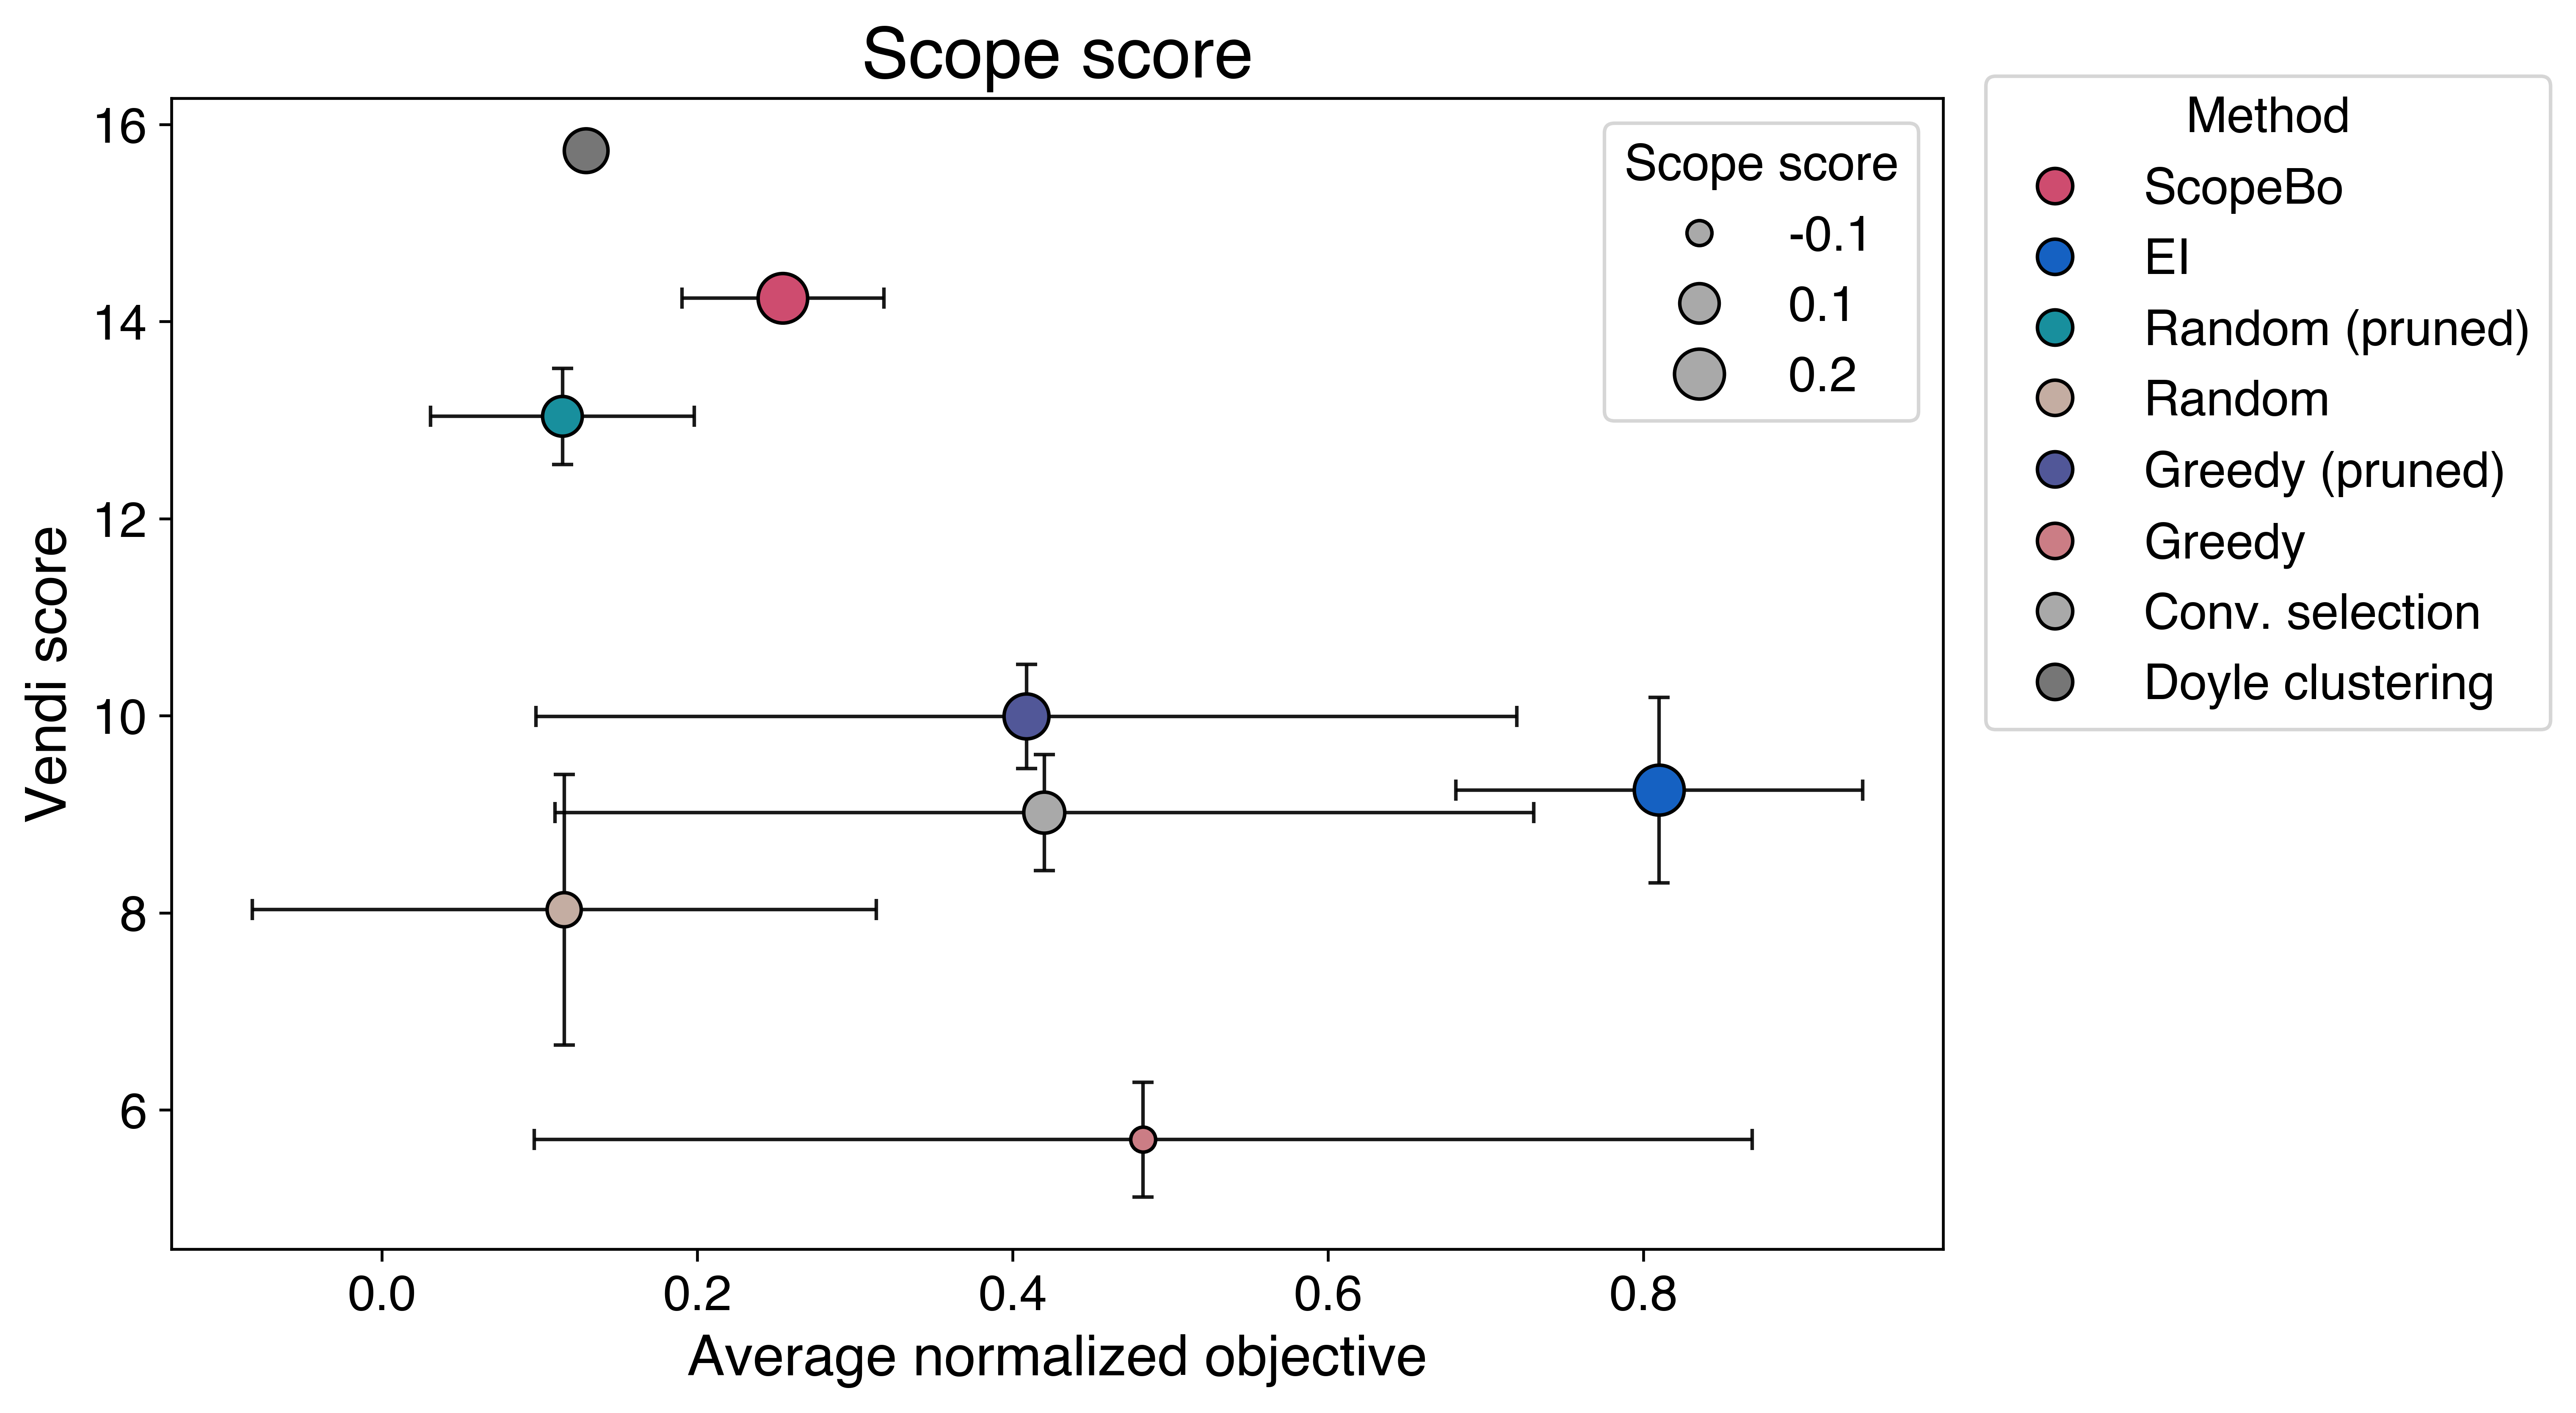

,Av. norm. objective,Vendi score,Scope score
ScopeBo,0.254,14.235,0.203
EI,0.810,9.244,0.209
Random (pruned),0.114,13.038,0.076
Random,0.116,8.031,0.016
Greedy (pruned),0.409,9.992,0.140
Greedy,0.483,5.698,-0.063
Conv. selection,0.420,9.016,0.091
Doyle clustering,0.129,15.733,0.124


In [25]:
# Plot the results
x = map_df.iloc[0]
y = map_df.iloc[1]
xerr = std_df.iloc[0]
yerr = std_df.iloc[1]
raw_size_data = map_df.iloc[2]

size_min, size_max = 50, 200
data_min, data_max= raw_size_data.min(), raw_size_data.max()
sizes = size_min + (raw_size_data - data_min) * (size_max - size_min) / (data_max - data_min)

# simplify the labels for the legend
labels = map_df.columns
labels = list(labels)
for i,val in enumerate(labels):
    if val == "EI_pruning":
        labels[i] = "ScopeBO"
    elif "no-pruning" in val:
        labels[i] = val.split("_")[0]
    elif "_pruning" in val:
        labels[i] = val.split("_")[0] + " (pruned)"
map_df.columns = labels


color_map = {label: all_colors[i] for i, label in enumerate(labels)}
colors = [color_map[label] for label in labels]
alpha_val = 1

plt.figure(figsize=(9,6),dpi=600)
plt.title(f"Performance map")
plt.scatter(x, y, s=sizes, alpha=alpha_val, c = colors, edgecolors="k")
# Add error bars
plt.errorbar(
    x, y,
    xerr=xerr,
    yerr=yerr,
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=3,
    alpha=0.9,
    zorder=0
)


plt.xlabel('Average normalized objective')
plt.ylabel('Vendi score')
plt.title('Scope score')

# legend for the methods
color_legend = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=label,
        markerfacecolor=color_map[label],
        alpha=alpha_val,
        markeredgecolor='k',
        markersize=10
    )
    for label in labels
]

# legend for scope score
# Choose representative raw size values
size_legend_values = np.linspace(raw_size_data.min(), raw_size_data.max(), 3)
size_legend_sizes = size_min + (size_legend_values - data_min) * (size_max - size_min) / (data_max - data_min)
size_legend = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'{val:.1f}',
        markerfacecolor=all_colors[6],
        alpha=alpha_val,
        markeredgecolor='k',
        markersize=np.sqrt(s)
    )
    for val, s in zip(size_legend_values, size_legend_sizes)
]

# Add legends
first_legend = plt.legend(handles=color_legend, loc = "lower left", title="Method", frameon=True,
                          bbox_to_anchor=(1.01, 0.43))
plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=size_legend, title="Scope score", frameon=True)

plt.show()

map_df.index = ["Av. norm. objective", "Vendi score", "Scope score"]
map_df.applymap(lambda x: round(x,3)).T

In [26]:
std_df.applymap(lambda x: round(x,3)).T

,Average norm. objective,Vendi score,Scope score
ScopeBo,0.064,0.192,0.052
EI,0.129,0.942,0.077
Random (pruned),0.084,0.487,0.056
Random,0.198,1.372,0.027
Greedy (pruned),0.311,0.528,0.102
Greedy,0.386,0.582,0.055
Conv. selection,0.310,0.588,0.075
Doyle clustering,0.000,0.000,0.000


ScopeBO and EI achieve essentially the same leading scope score. ScopeBO has a stronger focus on the diversity (higher Vendi score), but EI achieves a higher performance of the selected samples. While the scope scores are nearly the same, ScopeBO has a lower standard deviation in both the average objective and Vendi score, leading to more consistent results across the different initiations. 

### Visualization of scope examples

Show the scopes for the random seed that provides a scope performance closest to the average of all random seeds (for ScopeBO scopes). Scopes for other methods are shown with the same random seed.

In [27]:
def find_av_random_seed(name_results, bounds, batch_pruning, budget=27):
    """Finds the random seed that give the scope with a scope score closet to the average performance."""

    _, dict_dfs_raw_data = Benchmark.get_metric_overview(bounds=bounds,budget=budget,type_results="scope", 
                                name_results=name_results)

    # dict_dfs_raw_data contains the a dict for each batch-pruning 
    # combination which in turn contains a dict of the raw data for the differnt random seeds
    # --> restrict to the relevant data (batch size 2 and no Vendi pruning)
    dfs_raw_data = dict_dfs_raw_data[batch_pruning]

    # collect the scope scores
    # NOTE: the indices are the (zero-indexed) rounds --> round 8 is the full scope of 27 samples
    score_dict = {seed: df.loc[8,"scope"] for seed,df in dfs_raw_data.items()}
    av_score = np.mean(np.array(list(score_dict.values())))

    # calculate the absolute difference to the average score
    score_diff = {seed: abs(score-av_score) for seed,score in score_dict.items()}

    # get the seed that is closest to the average
    av_seed = min(score_diff,key=score_diff.get)

    return av_seed


def get_umap(name_results, objective, hyperpar="balanced_b3_V13", bounds = bounds, seed = None,figsize=(2.7,2.7), show_colorbar=False):

    if seed is None:
        seed = find_av_random_seed(name_results= name_results, bounds=bounds, batch_pruning= "_".join(hyperpar.split("_")[1:]))
    print("Depicted seed:",seed)
    Benchmark().track_samples(filename_umap=f"./suzuki_UMAP_coords.csv",
                            filename_data=f"27{hyperpar}_s{seed}.csv",
                            bounds=bounds, cbar_title= f"{objective.split('_')[1].capitalize()} (%)",
                            hide_axis = True, obj_plot_bounds=(100,0),
                            filename_labelled=f"./suzuki_labelled_data.csv",
                            name_results= name_results+ "/raw_data", show_colorbar= show_colorbar, obj_to_display=objective,
                            label_round=False, display_cut_samples=False, figsize = figsize, size_scaling = 0.3, dpi=600)
    
    return seed

UMAPs for ScopeBO:

Depicted seed: 18
Scope score: 0.203
Average objective (scaled on [0,1]-scale): 0.251
Average objective_conversion: 23.878
Average objective_selectivity: 33.828
Vendi score: 14.357


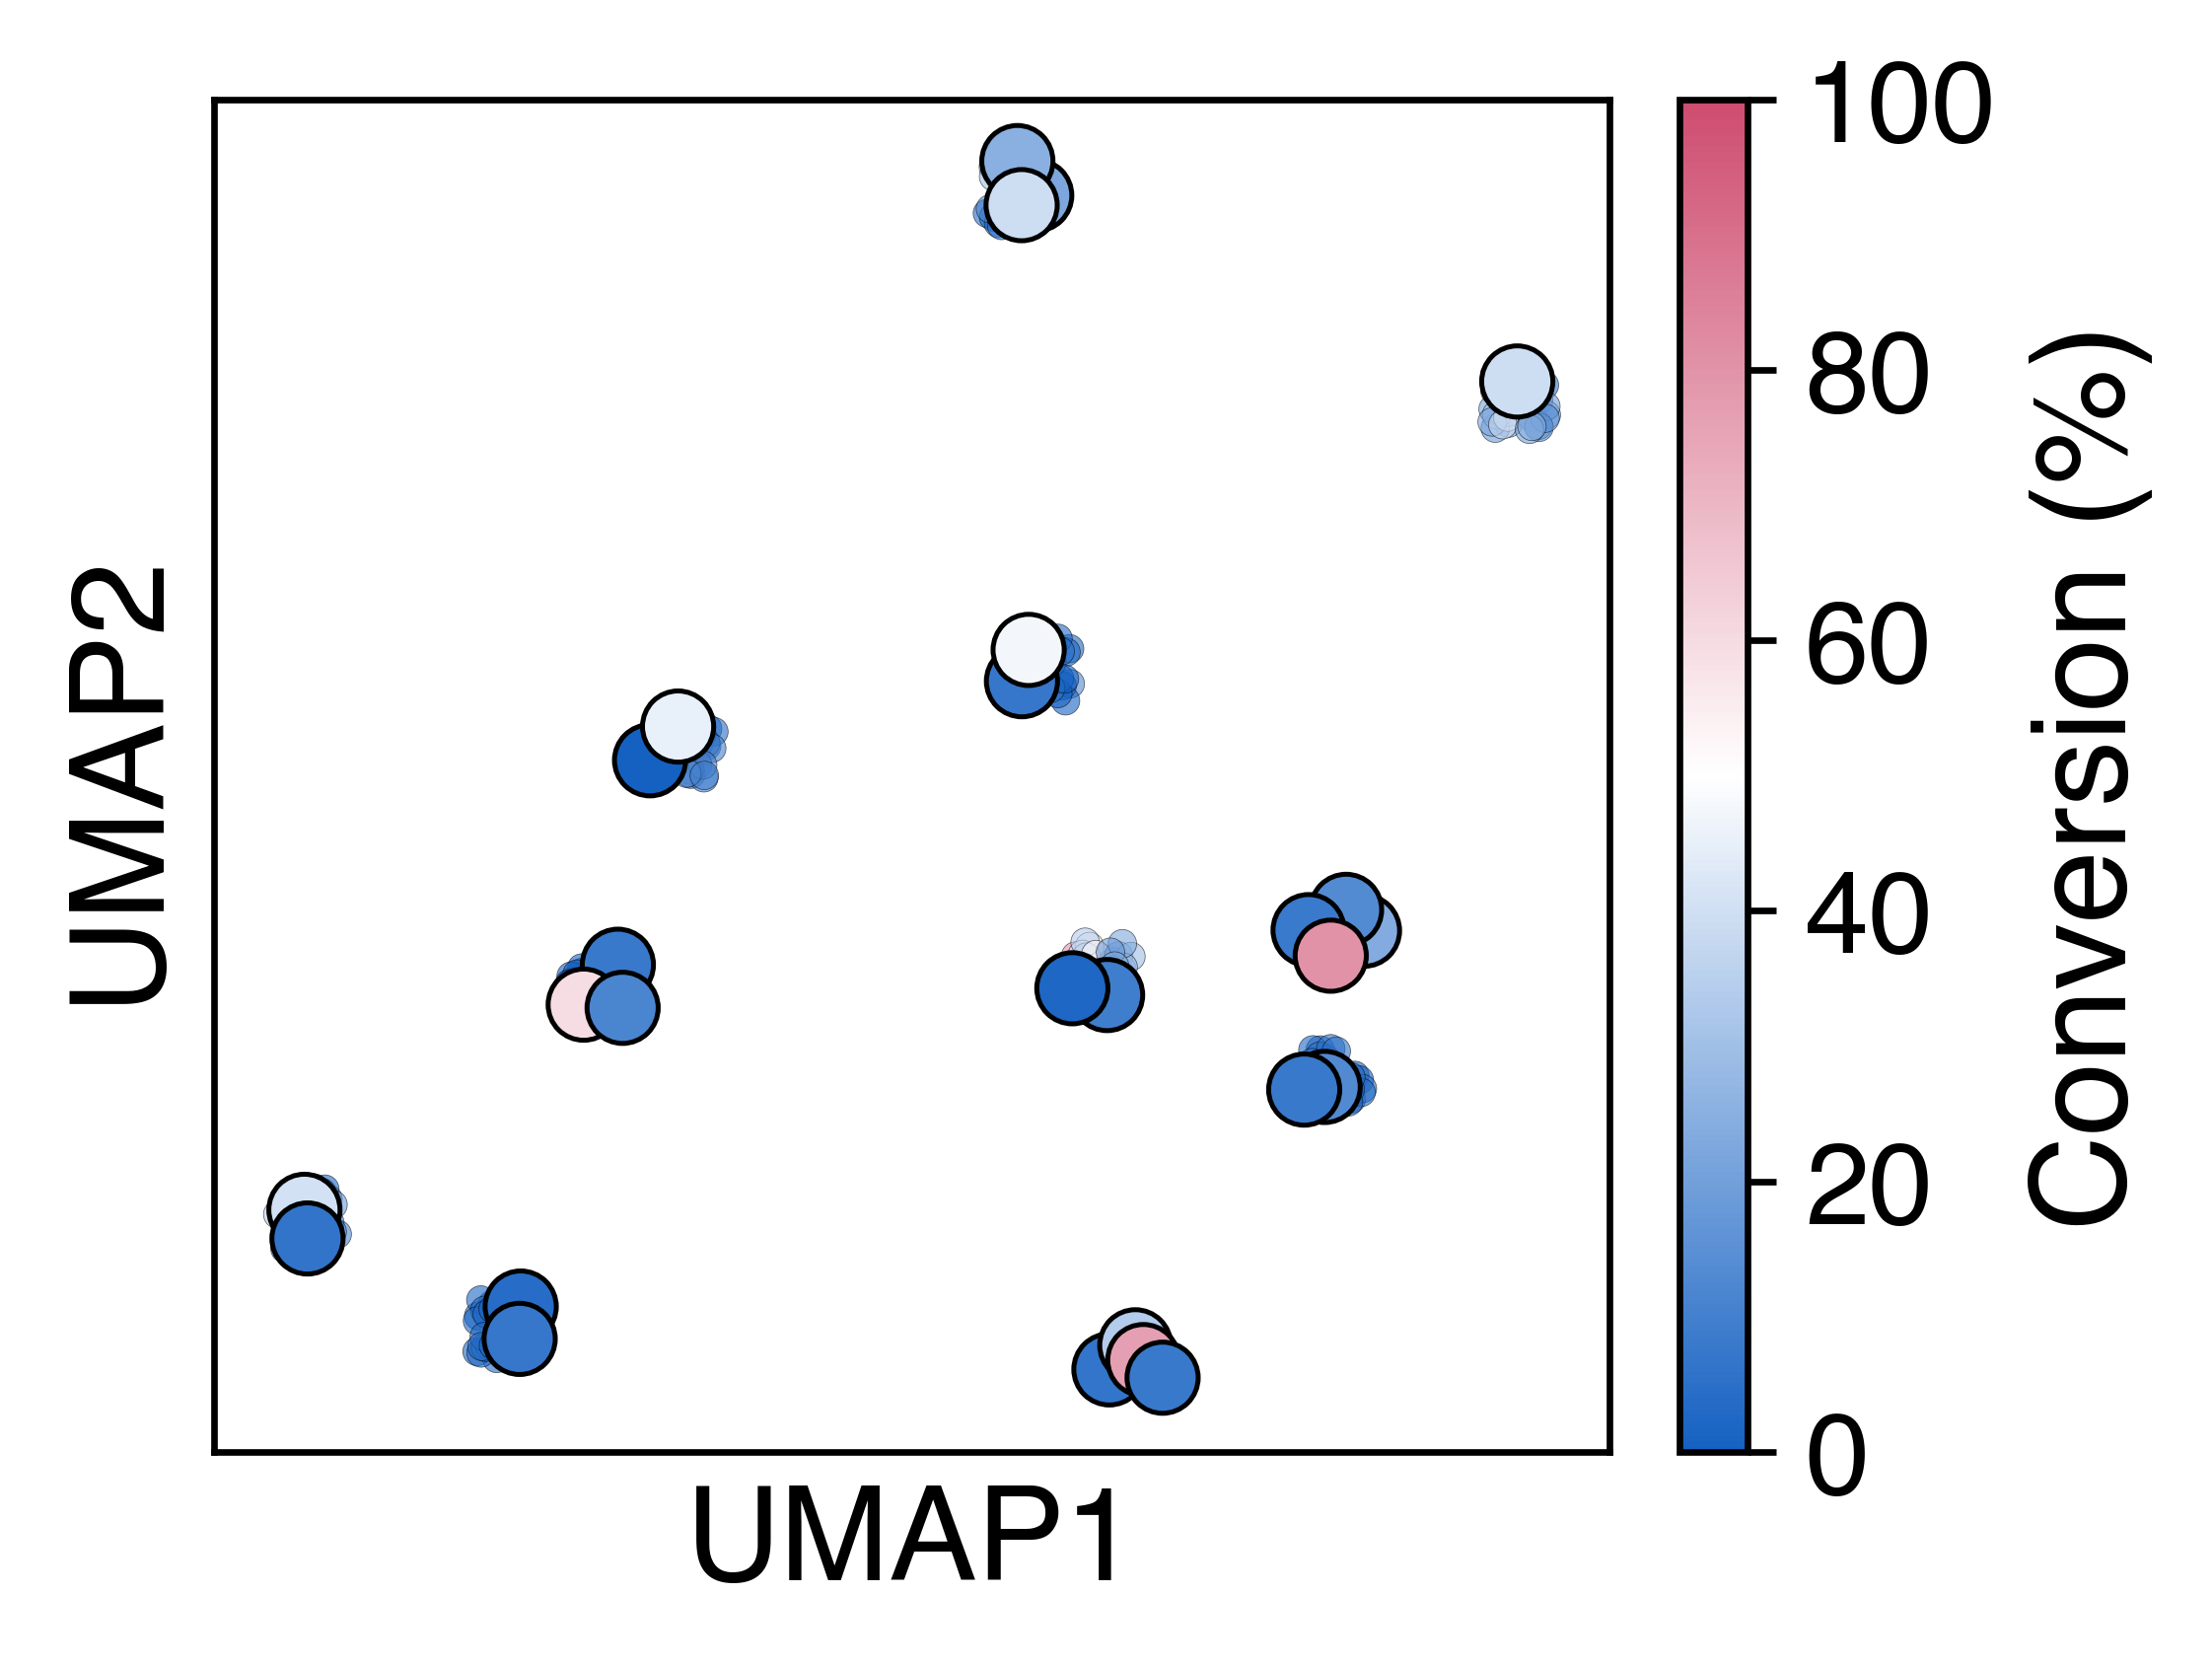

Depicted seed: 18
Scope score: 0.203
Average objective (scaled on [0,1]-scale): 0.251
Average objective_conversion: 23.878
Average objective_selectivity: 33.828
Vendi score: 14.357


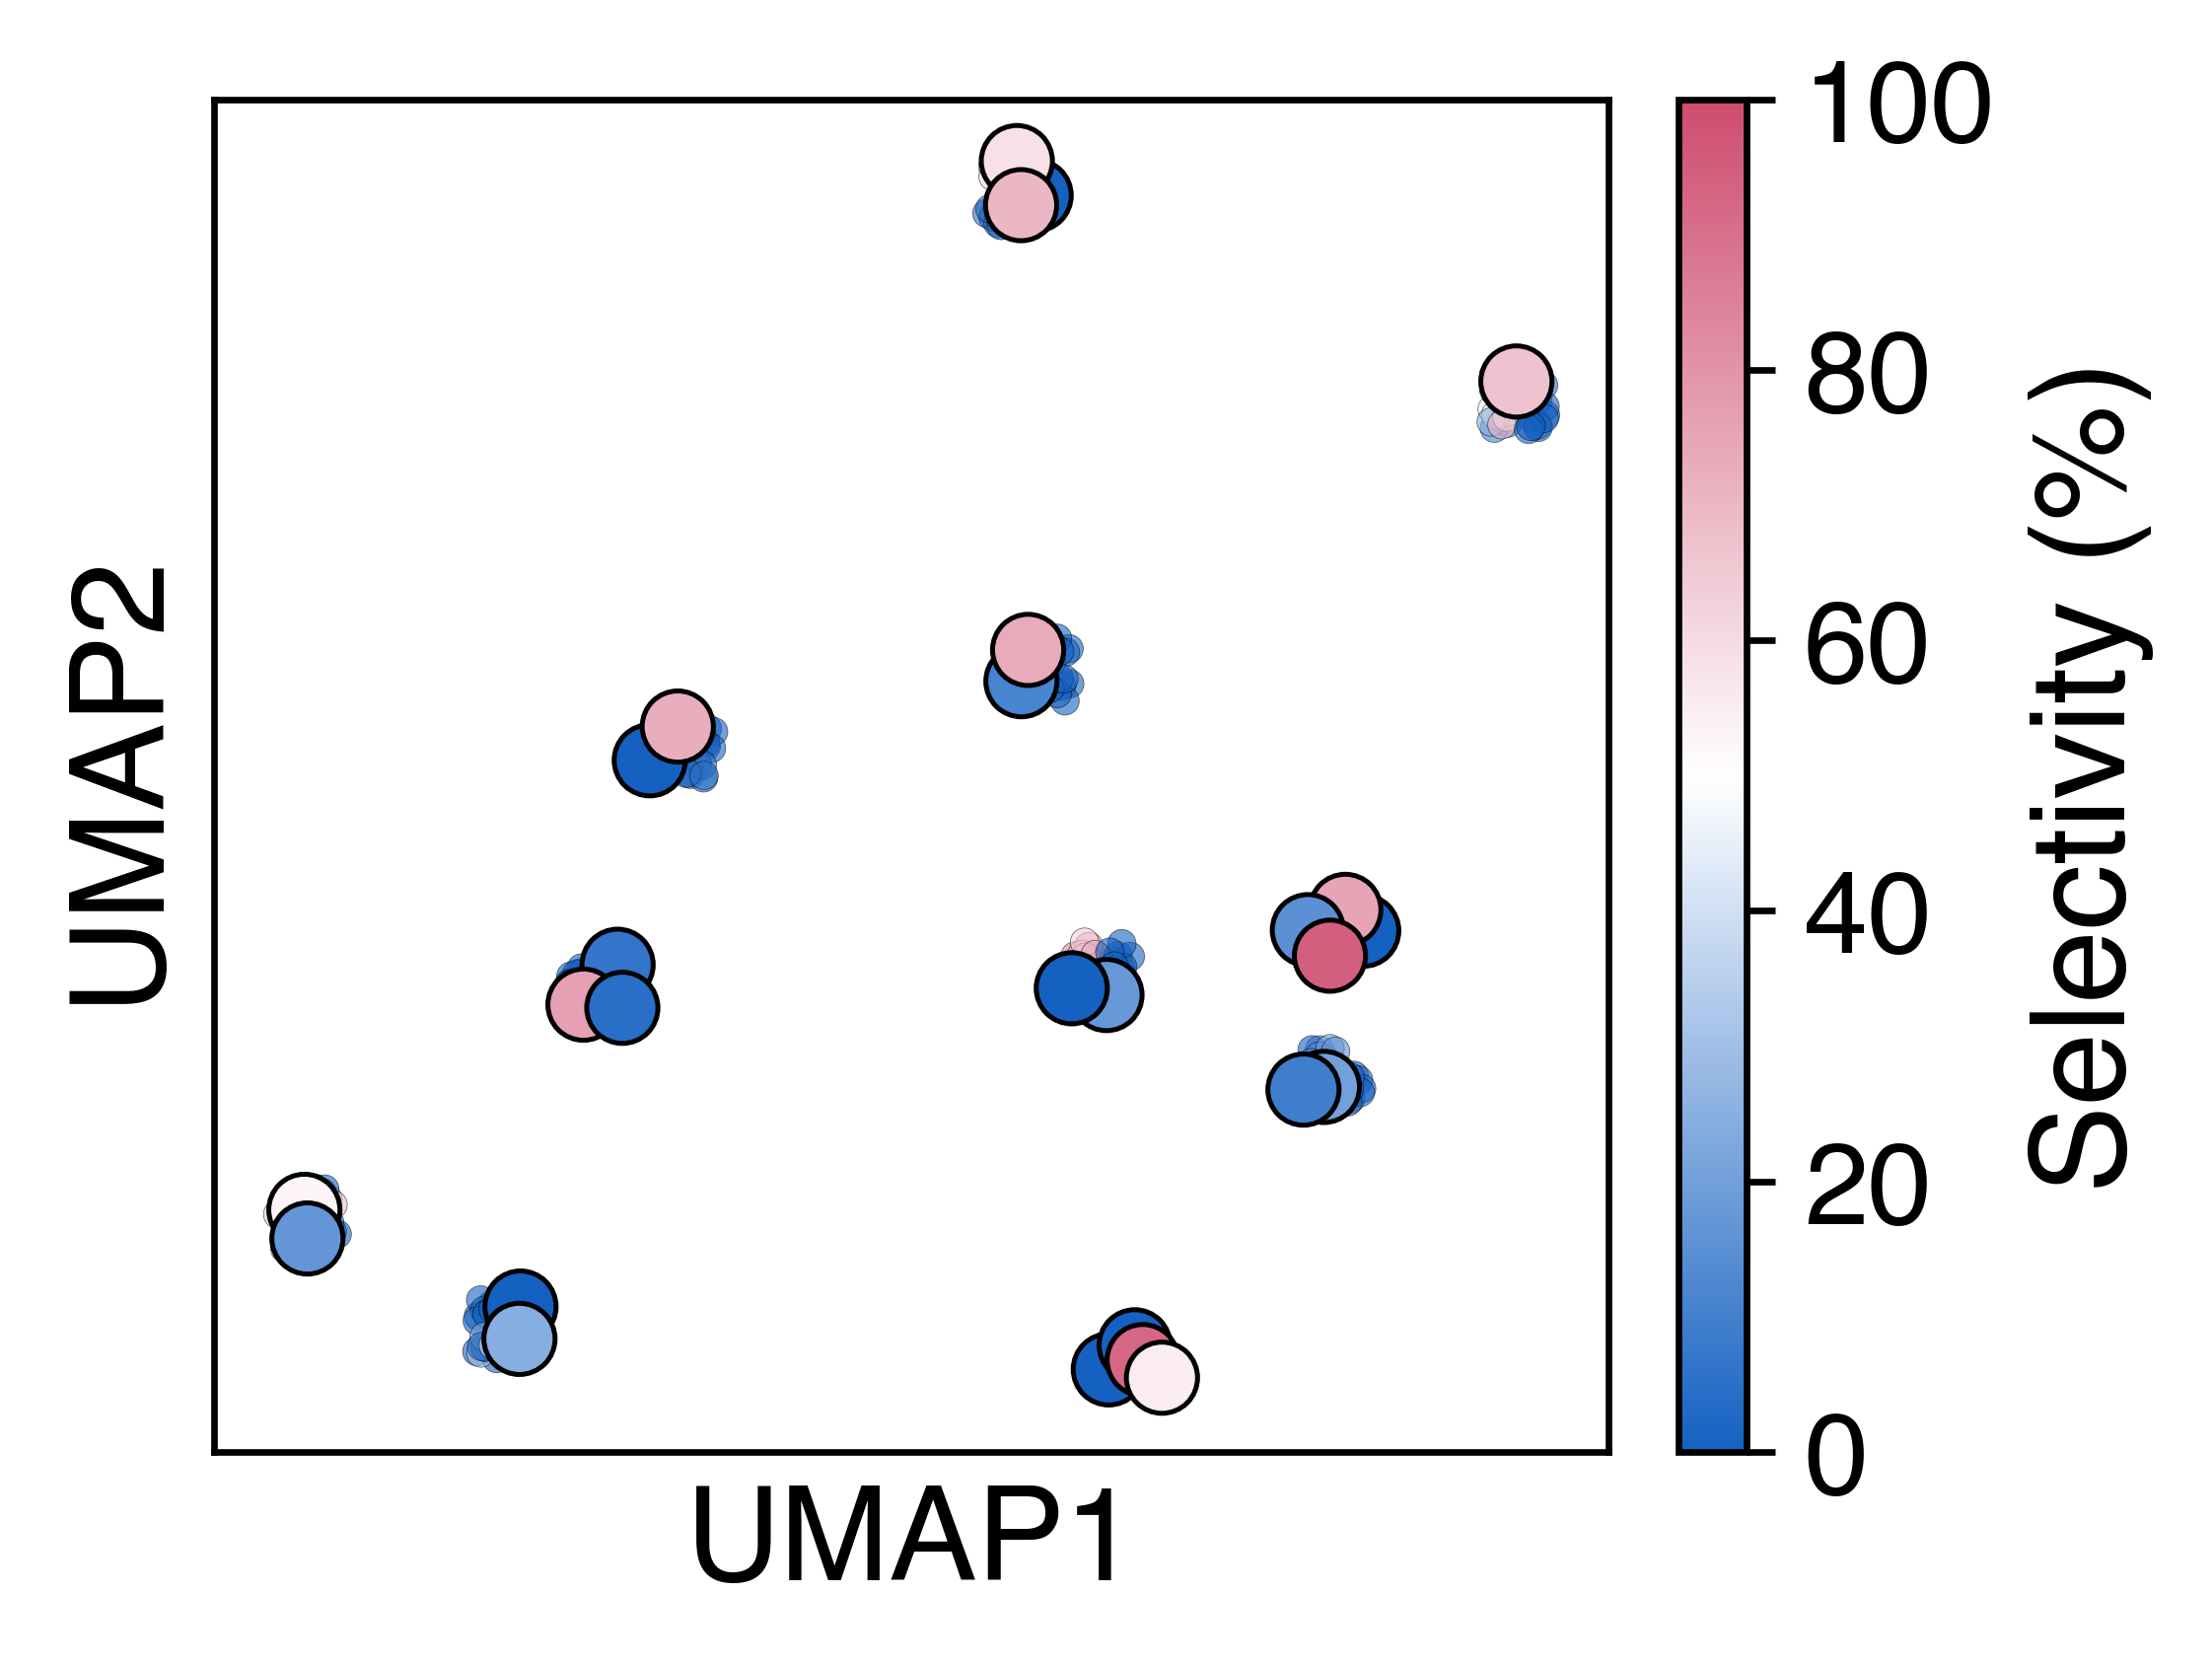

UMAPs for Regular BO (EI):

Depicted seed: 18
Scope score: 0.264
Average objective (scaled on [0,1]-scale): 0.539
Average objective_conversion: 36.615
Average objective_selectivity: 45.844
Vendi score: 11.384


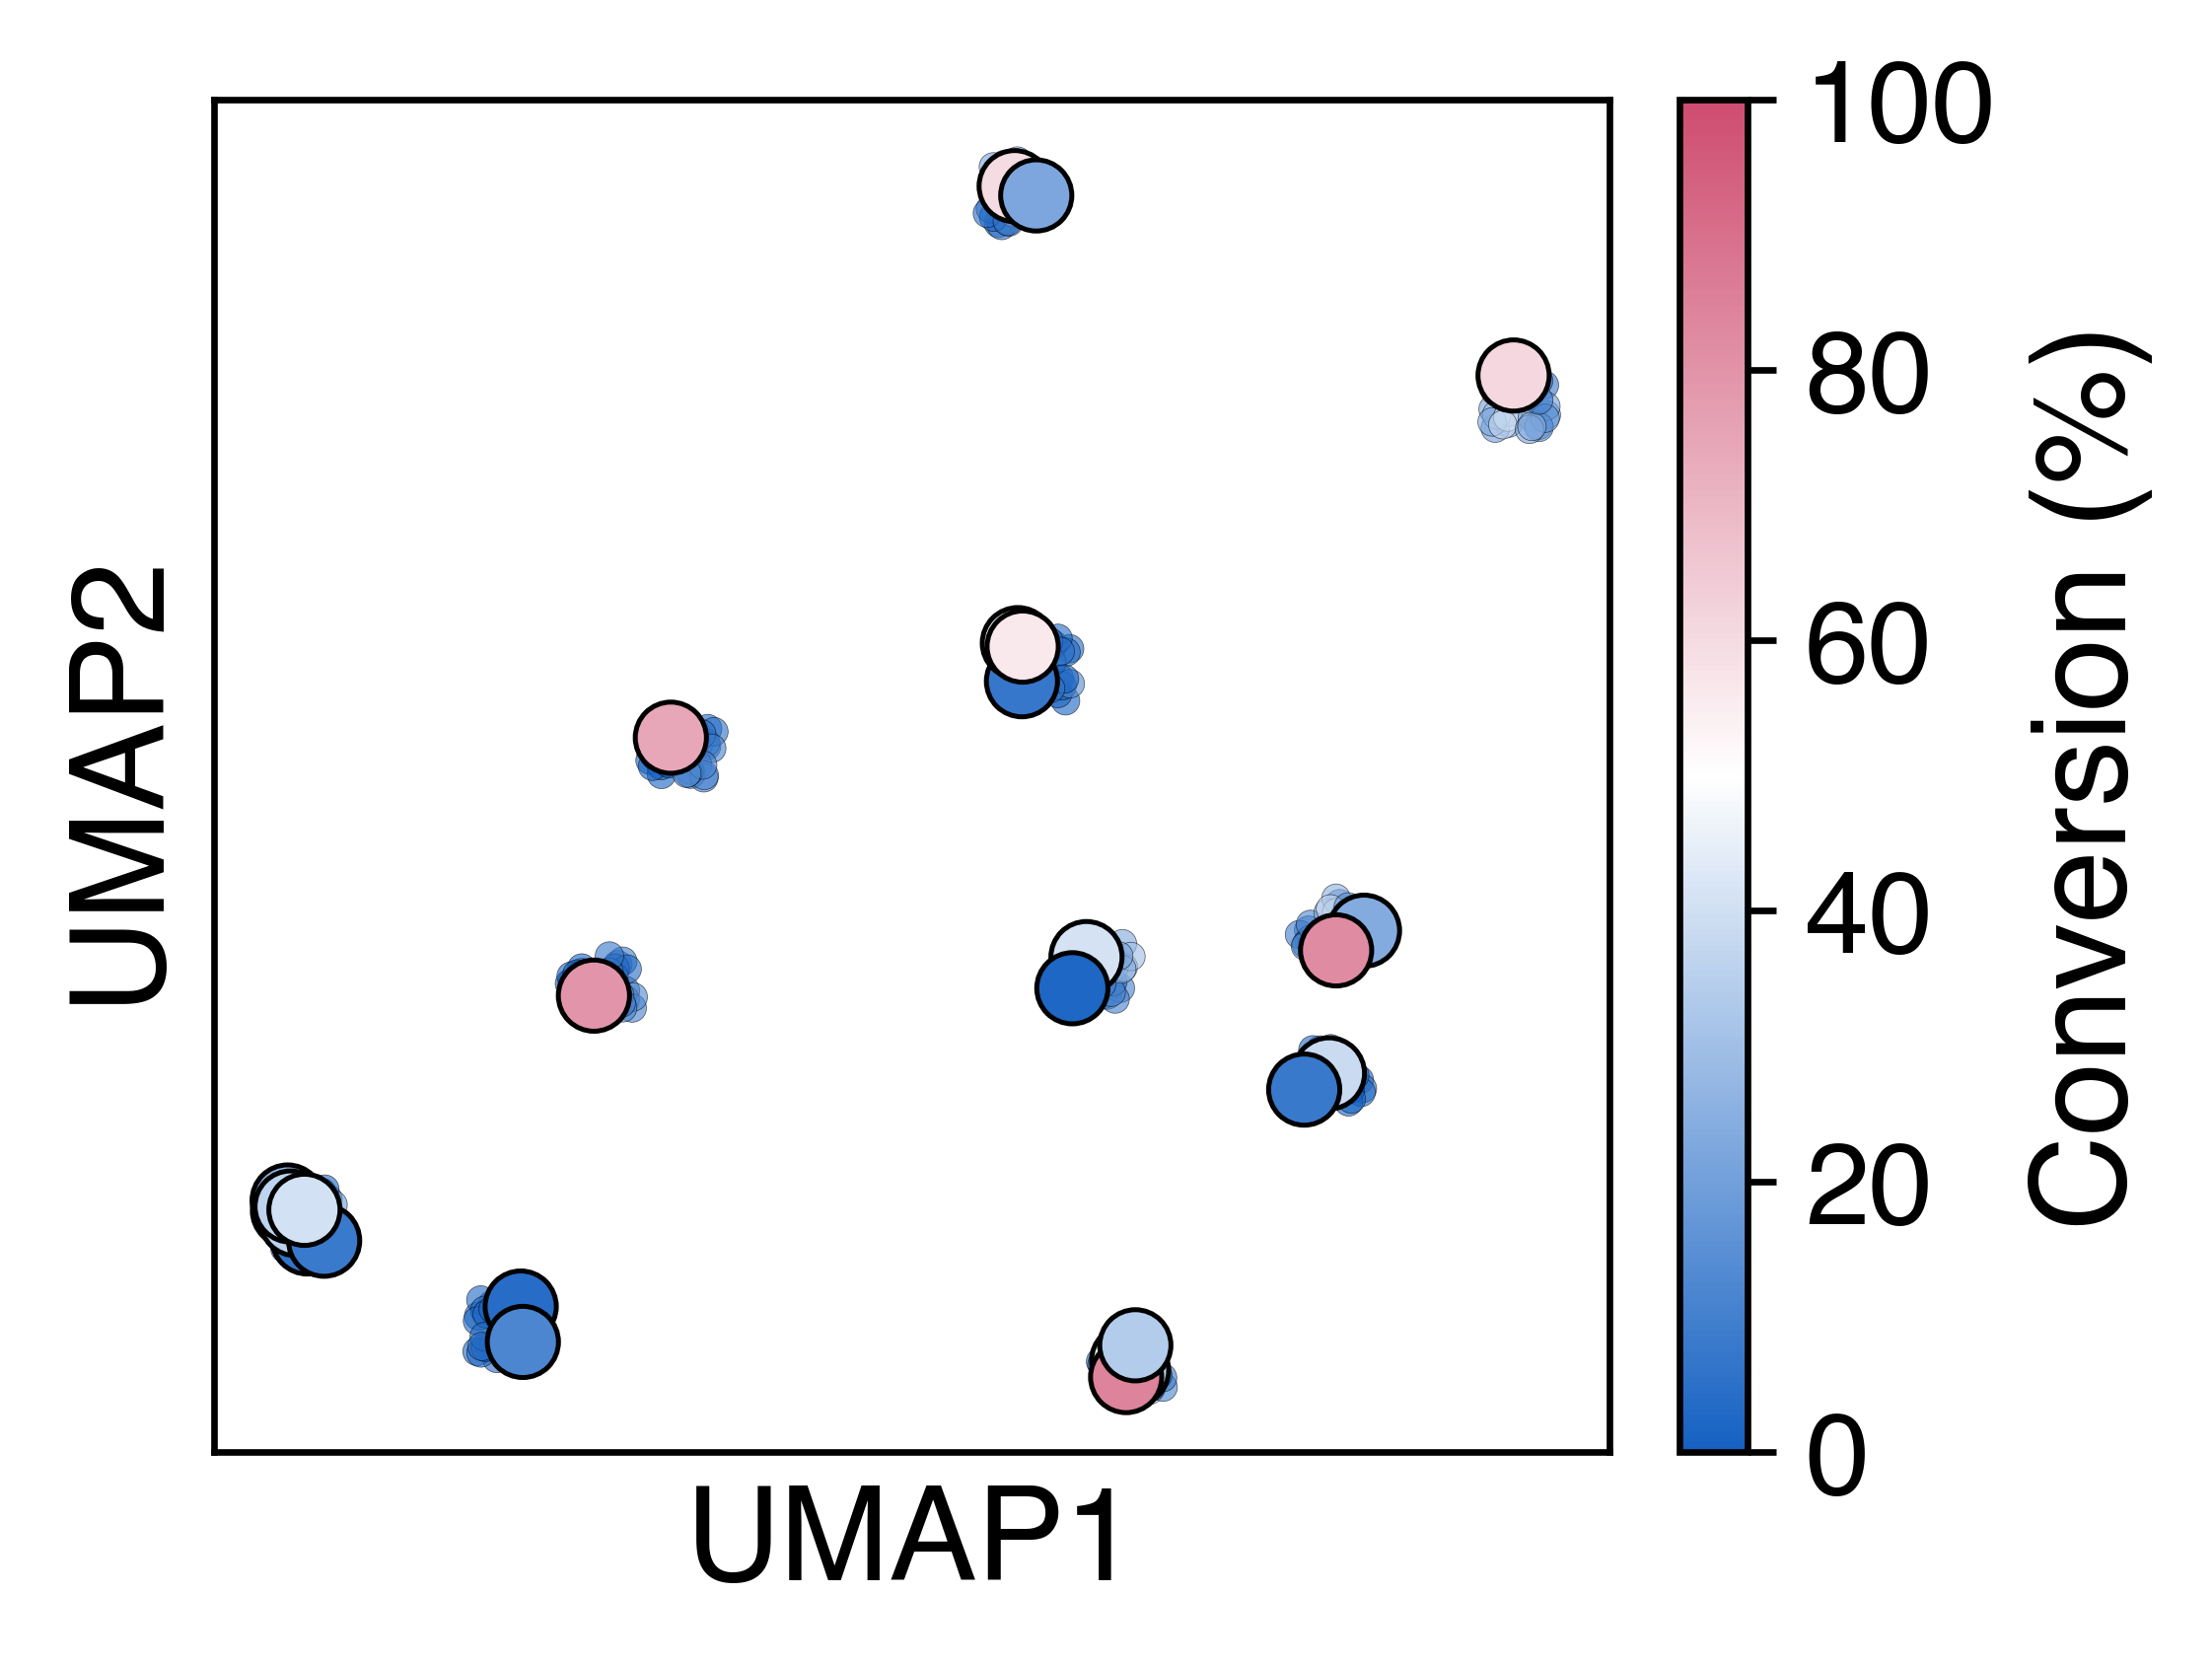

Depicted seed: 18
Scope score: 0.264
Average objective (scaled on [0,1]-scale): 0.539
Average objective_conversion: 36.615
Average objective_selectivity: 45.844
Vendi score: 11.384


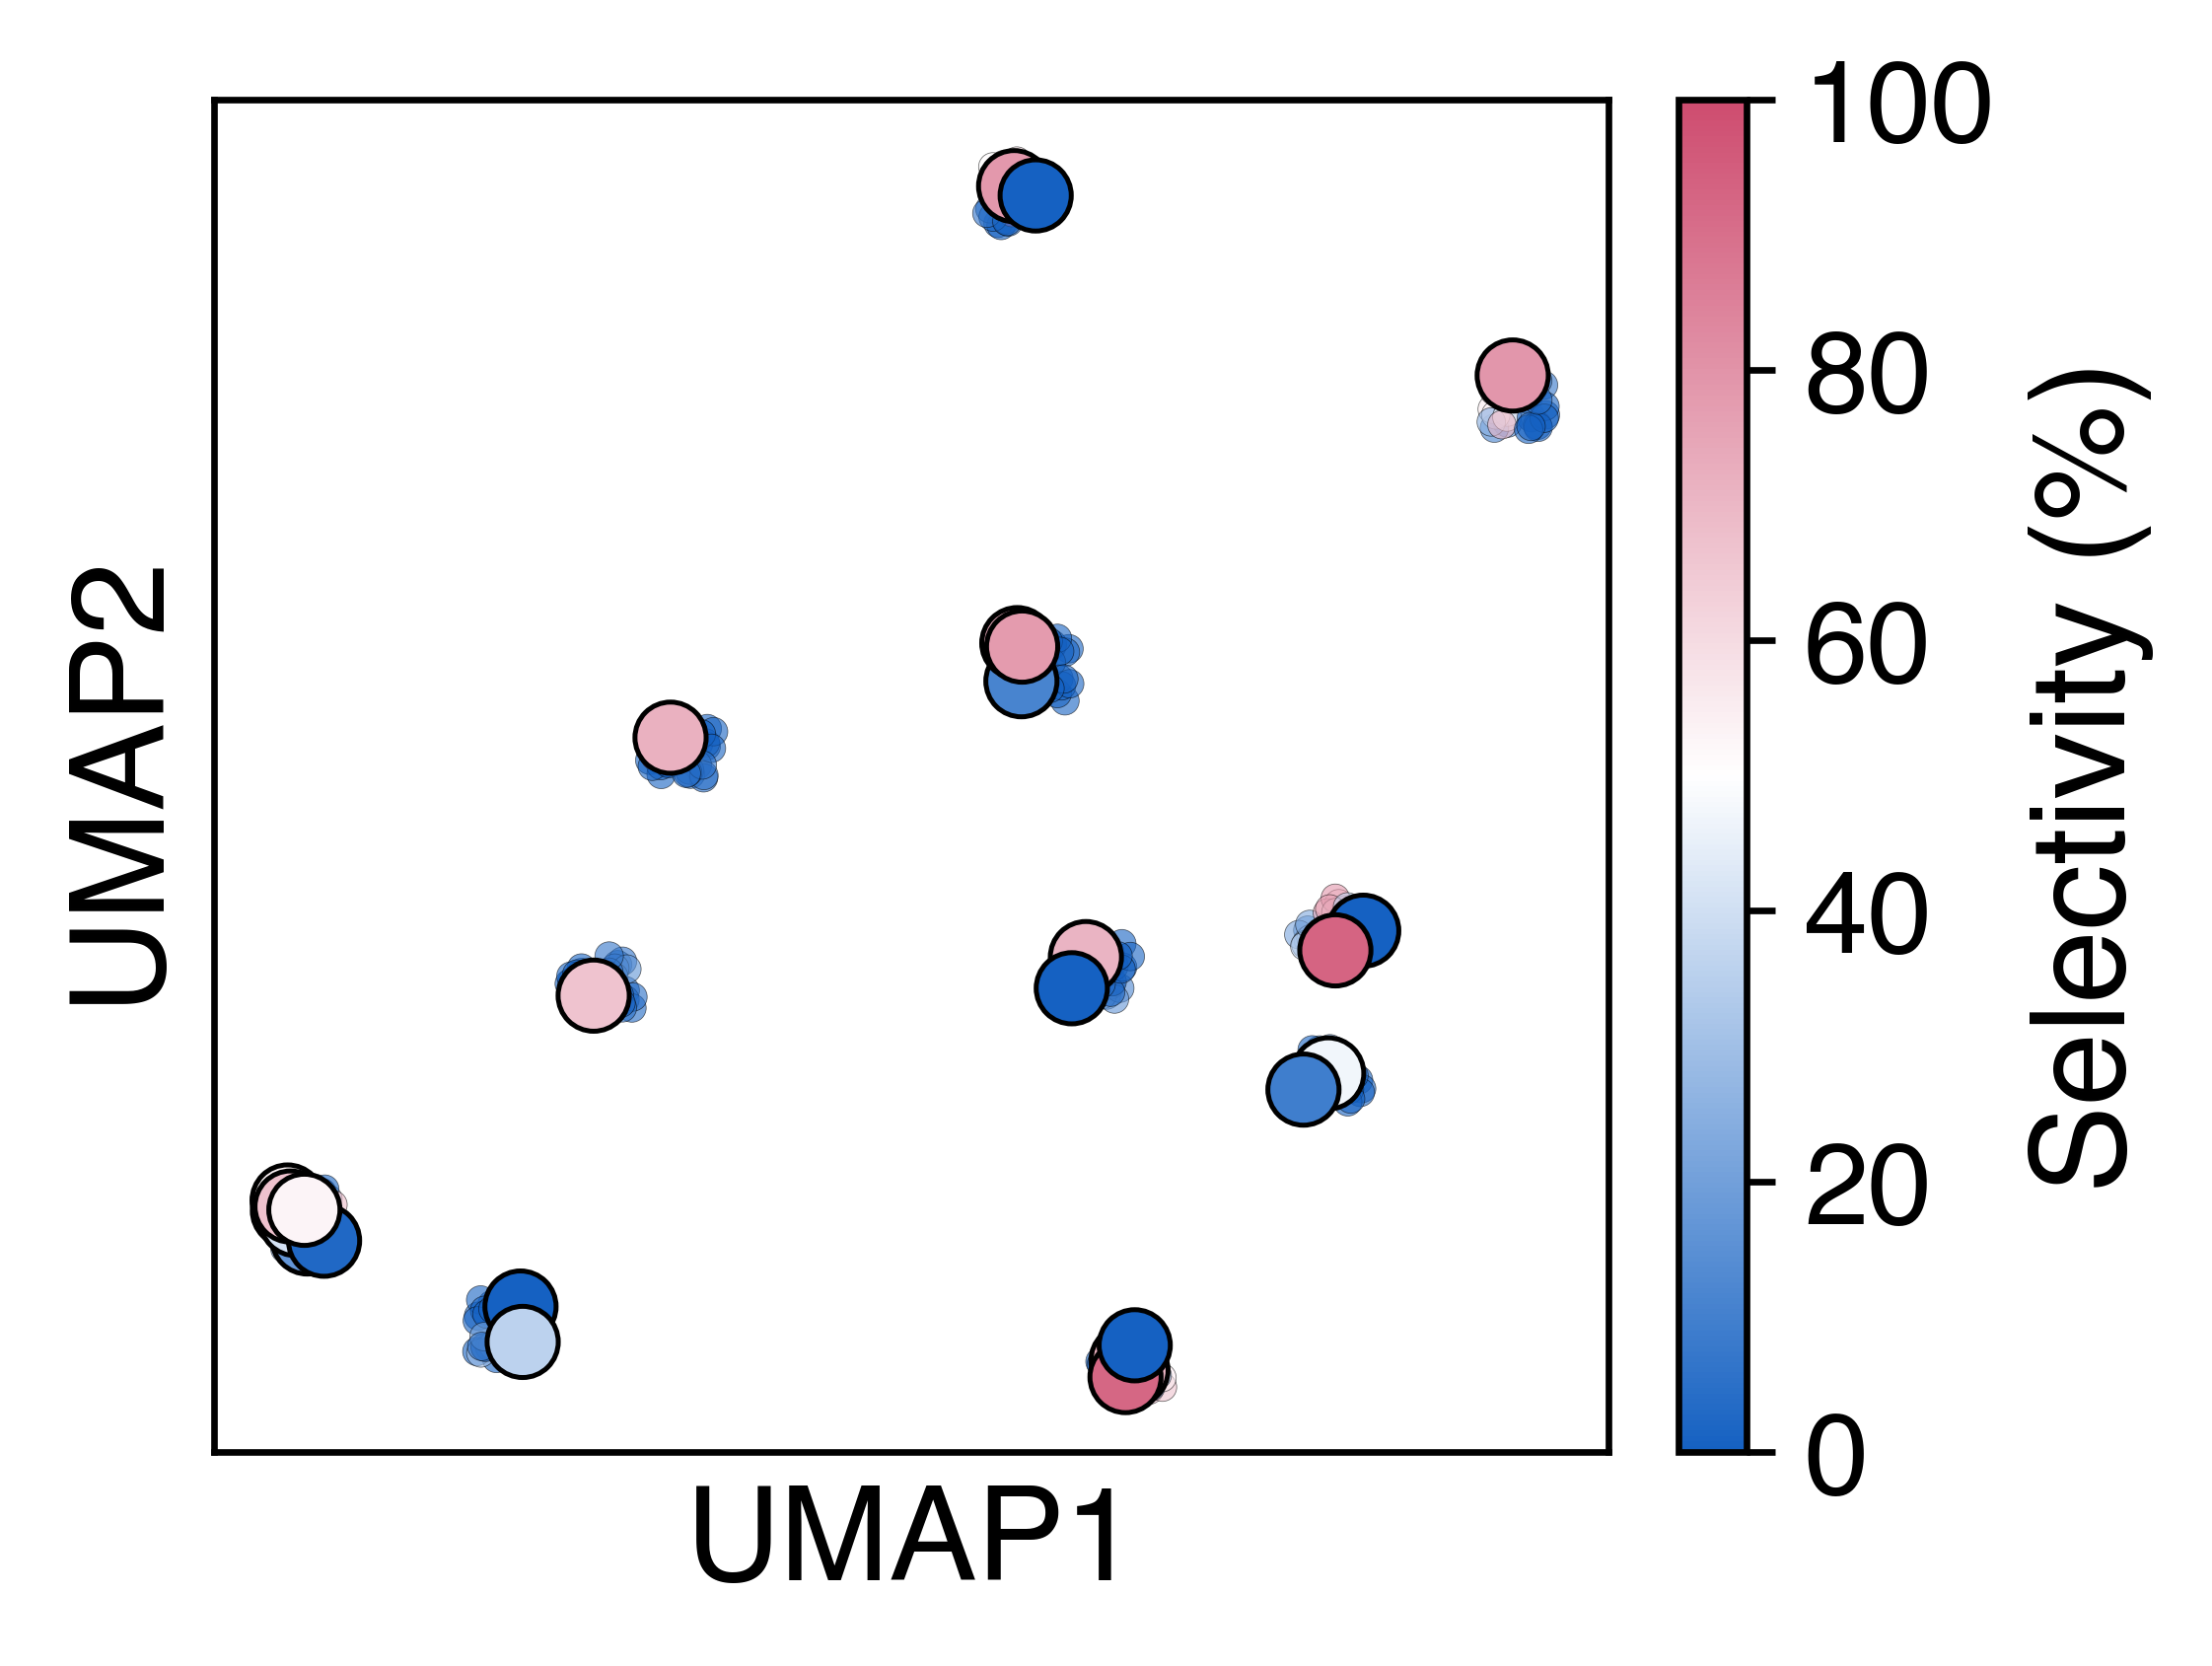

UMAPs for conventional selection:

Depicted seed: 18
Scope score: -0.023
Average objective (scaled on [0,1]-scale): -0.079
Average objective_conversion: 13.989
Average objective_selectivity: 14.629
Vendi score: 9.587


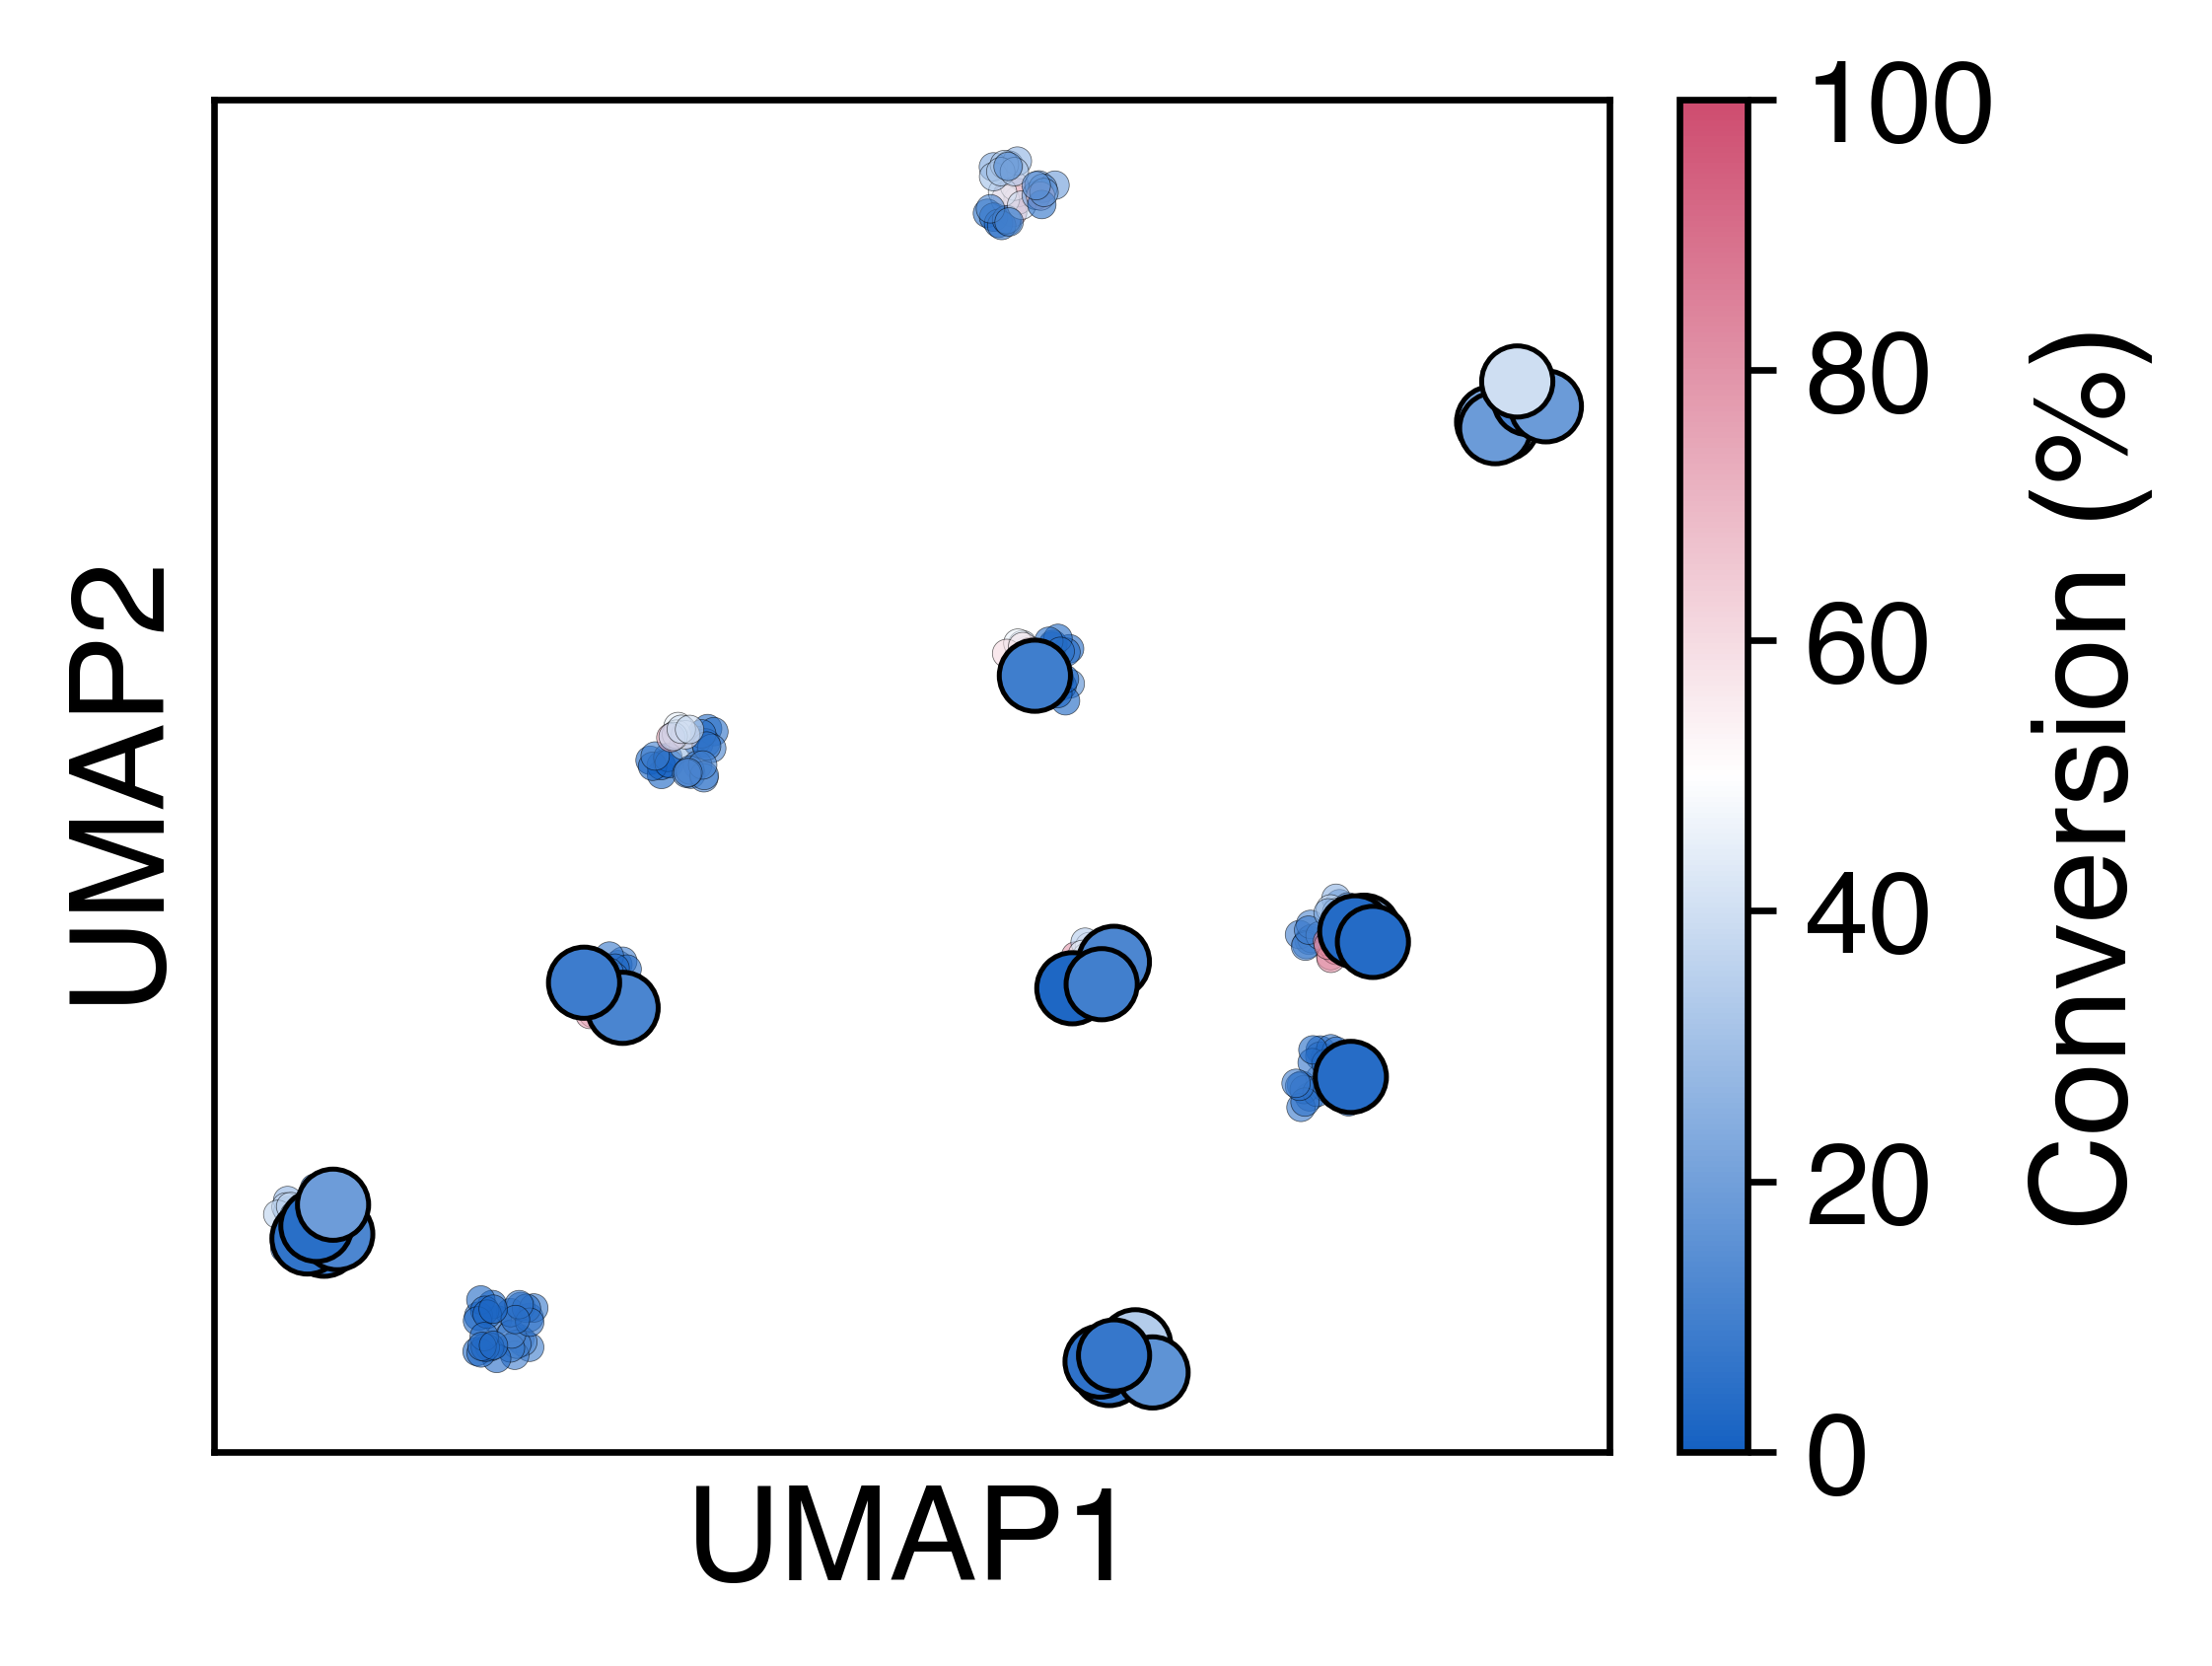

Depicted seed: 18
Scope score: -0.023
Average objective (scaled on [0,1]-scale): -0.079
Average objective_conversion: 13.989
Average objective_selectivity: 14.629
Vendi score: 9.587


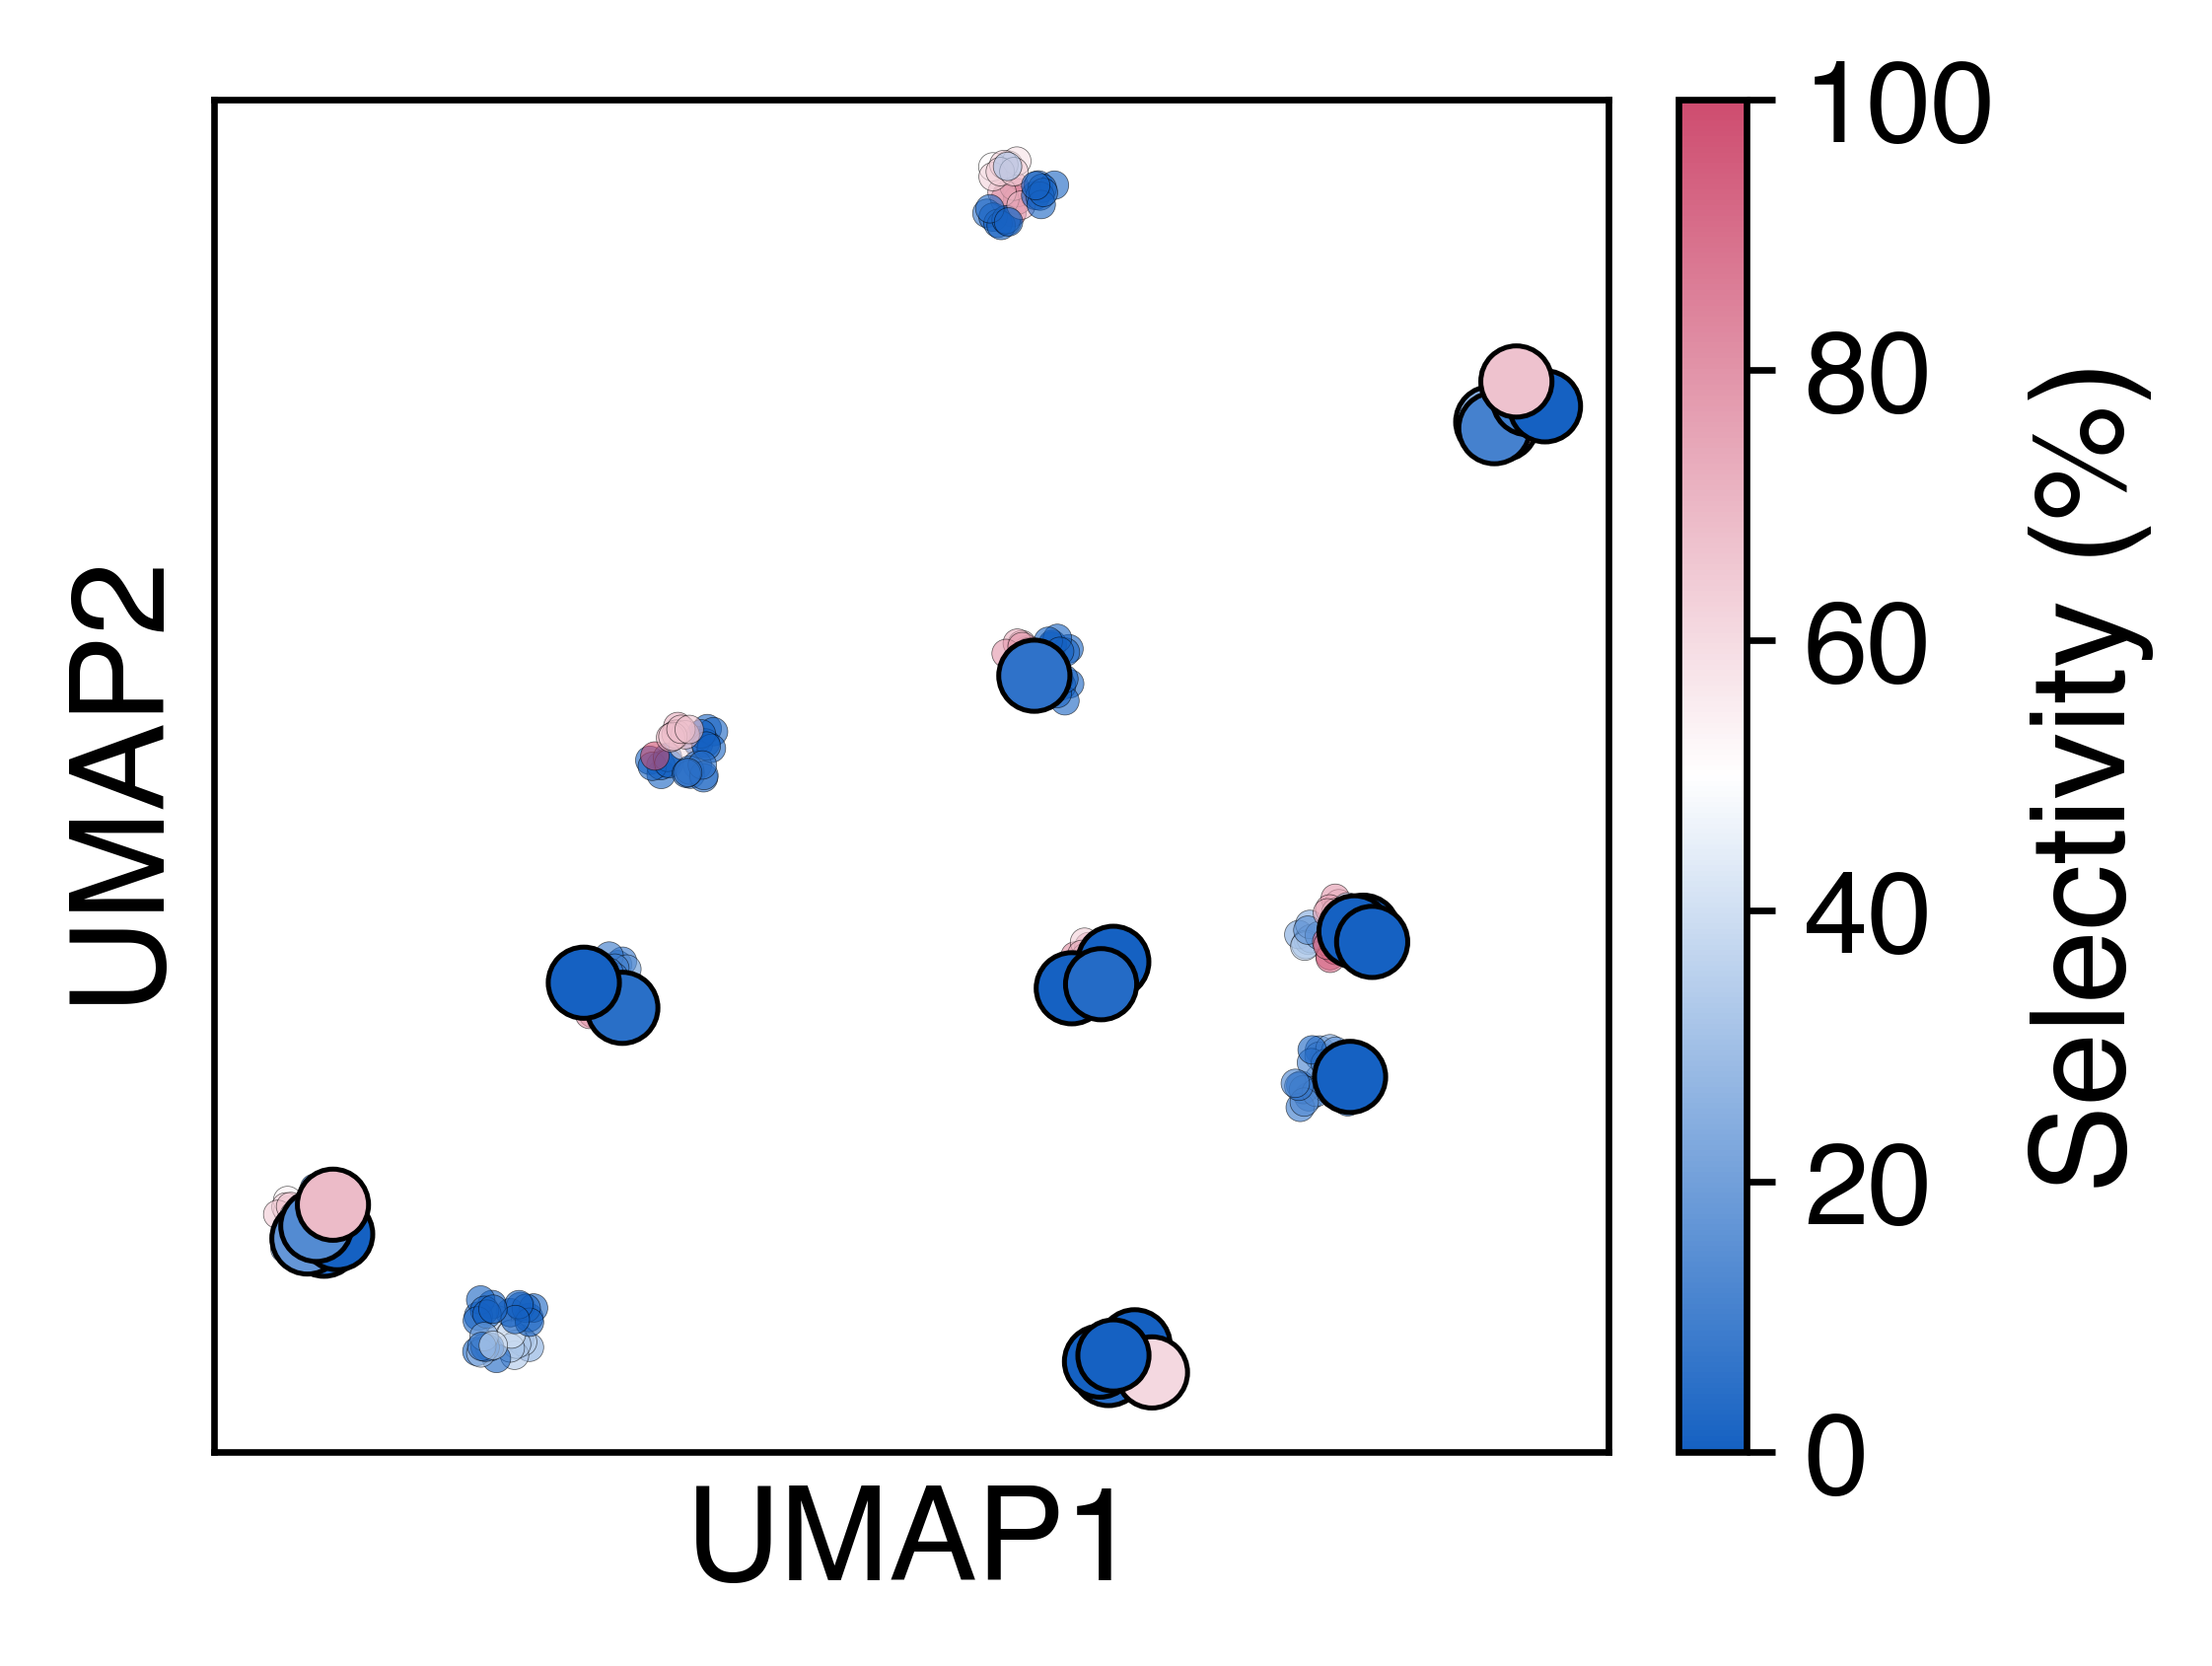

In [28]:
print(f"UMAPs for ScopeBO:\n")
seed = None
for obj in objectives:
    seed = get_umap(name_results=f"./Results_Data/scope_balanced_pruning", bounds=bounds, figsize = (3.63, 2.7), objective = obj, show_colorbar=True)
print(f"UMAPs for Regular BO (EI):\n")
for obj in objectives:
    get_umap(name_results=f"./Results_Data/scope_balanced_no-pruning", bounds = bounds, hyperpar="balanced_b3_V0", 
             seed=seed, figsize = (3.63, 2.7), objective = obj, show_colorbar=True)
print(f"UMAPs for conventional selection:\n")
for obj in objectives:
    get_umap(name_results=f"./Results_Data/scope_human-like-acq", hyperpar="greedy_b3_V5", 
             seed = seed, bounds = bounds, figsize = (3.63, 2.7), show_colorbar=True, objective = obj)

Most of the EI baseline samples are concentrated on few higher performing cluster. The ScopeBO algorithm also sampled these clusters to gain information about their high performance, but more evenly sampled the rest of the chemical space, leading an improved Vendi score.